In [153]:
# Install necessary libraries
%pip install networkx jupyter matplotlib numpy pandas openpyxl basemap


[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [154]:
# Import libraries

import networkx as nx
import numpy as np
import pandas as pd
import time, timeit
import os
import openpyxl
from mpl_toolkits.basemap import Basemap as Basemap
import matplotlib.pyplot as plt
import re
import heapq
import math


In [155]:
folder_path = "real_topologies"
real_top = [file for file in os.listdir(folder_path) if file.endswith(".xlsx")]
df_nodes = []
df_edges = []

for file in real_top:
    file_path = os.path.join(folder_path, file)
    df_1 = pd.read_excel(file_path)
    df_2 = pd.read_excel(file_path, sheet_name=1)  # Read the second sheet (page) of the .xlsx file
    df_nodes.append(df_1)
    df_edges.append(df_2)

# Now have 2 list of dataframes, one is the nodes and the other is the edges


In [156]:
# Static methods for all vector operations used such as calculating euclidean distance, dot product, etc.
class VectorOperations:
    def __init__(self):
        pass

    @staticmethod
    def dot(v, w):  # Dot product of two vectors
        x, y = v
        X, Y = w
        return x * X + y * Y

    @staticmethod
    def length(v):  # Length of a vector (magnitude)
        x, y = v
        return (x * x + y * y) ** 0.5

    @staticmethod
    def vector(b, e):  # Subtraction of two vectors
        x, y = b
        X, Y = e
        return (X - x, Y - y)

    @staticmethod
    def unit(v):  # Normalize a vector
        x, y = v
        mag = VectorOperations.length(v)
        return (x / mag, y / mag)

    @staticmethod
    def distance(p0, p1):  # Distance between two points
        return VectorOperations.length(VectorOperations.vector(p0, p1))

    @staticmethod
    def scale(v, sc):  # Scale a vector by a scalar
        x, y = v
        return (x * sc, y * sc)

    @staticmethod
    def add(v, w):  # Add two vectors
        x, y = v
        X, Y = w
        return (x + X, y + Y)

    @staticmethod
    def pnt2line(pnt, start, end):  # Distance from point to line segment
        line_vec = VectorOperations.vector(start, end)
        pnt_vec = VectorOperations.vector(start, pnt)
        line_len = VectorOperations.length(line_vec)
        line_unitvec = VectorOperations.unit(line_vec)
        pnt_vec_scaled = VectorOperations.scale(pnt_vec, 1.0 / line_len)
        t = VectorOperations.dot(line_unitvec, pnt_vec_scaled)
        if t < 0.0:
            t = 0.0
        elif t > 1.0:
            t = 1.0
        nearest = VectorOperations.scale(line_vec, t)
        dist = VectorOperations.distance(nearest, pnt_vec)
        nearest = VectorOperations.add(nearest, start)
        return dist

    @staticmethod
    def dist_euclidean(p1, p2, pos):  # Euclidean distance between two points
        x1, y1 = pos[p1]
        x2, y2 = pos[p2]
        return ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5  # Calculate straight-line distance

    @staticmethod
    def vertical_distance(pnt, start, end):
        line_vec = VectorOperations.vector(start, end)
        pnt_vec = VectorOperations.vector(start, pnt)
        line_len = VectorOperations.length(line_vec)
        my_ans = abs(line_vec[0] * pnt_vec[1] - line_vec[1] * pnt_vec[0]) / line_len
        return my_ans
    
def dist_euclidean(node1, node2, pos):
    """Calculate Euclidean distance between two nodes using their positions"""
    x1, y1 = pos[node1]
    x2, y2 = pos[node2]
    dx = x2 - x1
    dy = y2 - y1
    return math.hypot(dx, dy)

def pnt2line(point, line_start, line_end):
    """Calculate shortest distance from point to line segment"""
    # Unpack coordinates
    px, py = point
    lsx, lsy = line_start
    lex, ley = line_end

    # Vector components
    abx = lex - lsx
    aby = ley - lsy
    apx = px - lsx
    apy = py - lsy

    # Projection calculation
    dot = abx * apx + aby * apy
    len_ab_sq = abx**2 + aby**2

    if len_ab_sq == 0:  # Line is actually a point
        return math.hypot(apx, apy)

    t = max(0.0, min(1.0, dot / len_ab_sq))
    proj_x = lsx + t * abx
    proj_y = lsy + t * aby

    return math.hypot(px - proj_x, py - proj_y)


In [157]:
def create_graph(df_nodes, df_edges):
    # Initialize the Basemap
    map = Basemap(
        projection='merc',
        lat_ts=0,
        resolution='i',
        suppress_ticks=True)
    
    

    # Extract node positions
    lon = df_nodes['Longitude'].values
    lat = df_nodes['Latitude'].values
    node_id = df_nodes["Node_ID"].values

    # Create position dictionary
    mx, my = map(lon, lat)
    pos = {node_id[i]: (mx[i], my[i]) for i in range(len(node_id))}

    # Extract edges with weights
    src = df_edges["Source"].values
    dest = df_edges["Destination"].values
    # weight = df_edges["Computed Length (km)"].values
    edges = []

    for i in range(len(src)):
        # Calculates the euclidean distance based on the (x,y) coordinates of the nodes insead of weightings
        weight = VectorOperations.dist_euclidean(src[i], dest[i], pos)
        edges.append((src[i], dest[i], weight))            

    # Create and populate the graph
    G = nx.Graph()
    G.add_weighted_edges_from(edges)
    return G, pos

def plot_graph(G, pos, title="Graph"):
    nx.draw_networkx(G, pos=pos, node_size=200)
    plt.title(title)
    plt.show()

# Graphs dictionary stores the graph as ab objects and the positions of the nodes

def create_graph_objects(real_top):
    graphs = {}
    for i in range(len(real_top)):
        nodes = df_nodes[i]
        edges = df_edges[i]
        G, pos = create_graph(nodes, edges)
        graphs[f"G{i}"] = G
        graphs[f"G{i}_pos"] = pos

# create_graph_objects(real_top)

In [158]:
"""TEST CODE fo getting maps that look good """

def create_graph(df_nodes, df_edges):
    # Initialize the Basemap
    m = 4
    map = Basemap(
        projection='merc',
        llcrnrlon=min(df_nodes["Longitude"]) - m,
        llcrnrlat=min(df_nodes["Latitude"]) - m - 8,
        urcrnrlon=max(df_nodes["Longitude"]) + m,
        urcrnrlat=max(df_nodes["Latitude"]) + m,
        resolution='i'
    )
    
    # Extract node positions
    lon = df_nodes['Longitude'].values
    lat = df_nodes['Latitude'].values
    node_id = df_nodes["Node_ID"].values

    # Create position dictionary
    mx, my = map(lon, lat)
    pos = {node_id[i]: (mx[i], my[i]) for i in range(len(node_id))}

    # Extract edges with weights
    src = df_edges["Source"].values
    dest = df_edges["Destination"].values
    # weight = df_edges["Computed Length (km)"].values
    edges = []

    for i in range(len(src)):
        # Calculates the euclidean distance based on the (x,y) coordinates of the nodes insead of weightings
        weight = VectorOperations.dist_euclidean(src[i], dest[i], pos)
        edges.append((src[i], dest[i], weight))            

    # Create and populate the graph
    G = nx.Graph()
    G.add_weighted_edges_from(edges)
    return G, pos, map

# Graphs dictionary stores the graph as ab objects and the positions of the nodes
def create_graph_objects(real_top):
    graphs = {}
    for i in range(len(real_top)):
        nodes = df_nodes[i]
        edges = df_edges[i]
        G, pos, map = create_graph(nodes, edges)
        graphs[f"G{i}"] = G
        graphs[f"G{i}_pos"] = pos
        graphs[f"G{i}_map"] = map
    return graphs

def plot_graph_with_map(G, pos, map, title="Detailed Map with Graph"):
    plt.figure(figsize=(12, 10))

    # Draw detailed map background
    map.drawcoastlines(color="black", linewidth=0.5)
    map.drawcountries(color="darkgray", linewidth=0.5)
    # map.drawrivers(color='blue', linewidth=0.3)
    map.drawstates()  # Draw state boundaries (USA only)
    map.drawcounties()  # Draw county boundaries (USA only)

    # Draw the graph on top of the map
    nx.draw_networkx_edges(G, pos, edge_color="blue", alpha=0.5, width=4)
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color="black", alpha=0.8)
    nx.draw_networkx_labels(G, pos, font_size=15, font_color="white", font_family="sans-serif")

    # Add a title
    plt.title(title, fontsize=30)
    plt.tight_layout()
    plt.show()

""" Run these functions to get the graph objects """
# graphs = create_graph_objects(real_top)
# plot_graph_with_map(graphs["G3"], graphs["G3_pos"], graphs["G3_map"], title="Representation of Graph 1 (USA)")

' Run these functions to get the graph objects '

dict_keys(['G0', 'G0_pos', 'G1', 'G1_pos', 'G2', 'G2_pos', 'G3', 'G3_pos', 'G4', 'G4_pos', 'G5', 'G5_pos', 'G6', 'G6_pos', 'G7', 'G7_pos', 'G8', 'G8_pos', 'G9', 'G9_pos', 'G10', 'G10_pos', 'G11', 'G11_pos', 'G12', 'G12_pos', 'G13', 'G13_pos', 'G14', 'G14_pos', 'G15', 'G15_pos', 'G16', 'G16_pos', 'G17', 'G17_pos', 'G18', 'G18_pos', 'G19', 'G19_pos', 'G20', 'G20_pos', 'G21', 'G21_pos', 'G22', 'G22_pos', 'G23', 'G23_pos', 'G24', 'G24_pos', 'G25', 'G25_pos', 'G26', 'G26_pos', 'G27', 'G27_pos', 'G28', 'G28_pos', 'G29', 'G29_pos', 'G30', 'G30_pos', 'G31', 'G31_pos', 'G32', 'G32_pos', 'G33', 'G33_pos', 'G34', 'G34_pos', 'G35', 'G35_pos', 'G36', 'G36_pos', 'G37', 'G37_pos', 'G38', 'G38_pos', 'G39', 'G39_pos', 'G40', 'G40_pos', 'G41', 'G41_pos', 'G42', 'G42_pos', 'G43', 'G43_pos', 'G44', 'G44_pos', 'G45', 'G45_pos', 'G46', 'G46_pos', 'G47', 'G47_pos', 'G48', 'G48_pos', 'G49', 'G49_pos', 'G50', 'G50_pos', 'G51', 'G51_pos', 'G52', 'G52_pos', 'G53', 'G53_pos', 'G54', 'G54_pos', 'G55', 'G55_pos', '

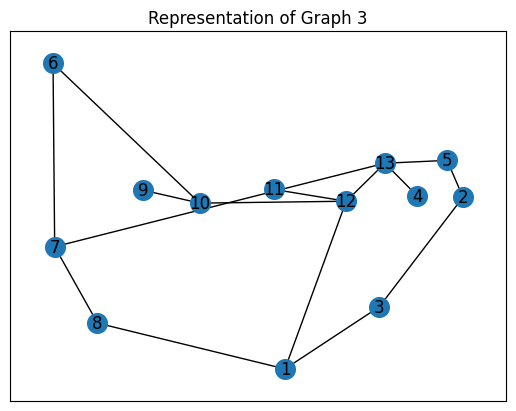

In [159]:
""" Loads the graph from the file so we dont need to run the other cells again """

import pickle
file_path = "graphs.pkl"

# Load the dictionary from the file
with open(file_path, "rb") as file:
    graphs = pickle.load(file)

graph_num = 3
print(graphs.keys())
plot_graph(graphs[f"G{graph_num}"], graphs[f"G{graph_num}_pos"], title=f"Representation of Graph {graph_num}")


In [160]:
"""
We are no longer using the weights from the excel file, instead we are calculating the euclidean distance between the nodes
"""

'\nWe are no longer using the weights from the excel file, instead we are calculating the euclidean distance between the nodes\n'

## Human Gaze Algorithm Implementation

In [161]:
import heapq
from collections import deque

# The next point is selected based on the shortest vertical distance to the starting point
def Human_gaze_algorithm_backtracking(Graph, start_node, end_node, pos):
    current_node = start_node
    visited_nodes = [start_node]
    dead_nodes = []
    while current_node != end_node:
        neighbors = list(Graph.neighbors(current_node))
        # neighbors are the neighbors of the current node
        for i in visited_nodes:
            if i in neighbors:
                neighbors.remove(i)
        for i in dead_nodes:
            if i in neighbors:
                neighbors.remove(i)
        # Ensure neighbors do not contain dead nodes and visited nodes
        # Remove visited nodes and dead nodes from neighbors
        
        if len(neighbors) == 0:
            visited_nodes.remove(current_node)
            dead_nodes.append(current_node)
        # If the current node has no neighbors, remove it from visited nodes and add it to dead nodes
            while len(neighbors) == 0:                                                  
                # Change the current node to the last one in visited nodes
                current_node = visited_nodes[-1]
                neighbors = list(Graph.neighbors(current_node))
            
                # is this still necessary if we have dead_nodes conditional?
                for i in visited_nodes:
                    if i in neighbors:
                        neighbors.remove(i)
                for i in dead_nodes:
                    if i in neighbors:
                        neighbors.remove(i)
                # Ensure neighbors do not contain dead nodes and visited nodes
                visited_nodes.remove(current_node) 
               
            visited_nodes.append(current_node) 
            
        options = {}
        
        for i in neighbors:
                options[i] = VectorOperations.pnt2line(pnt=pos[i], start=pos[start_node], end=pos[end_node])  # Distance from point to (start-end) line segment
        current_node = min(options, key=options.get) # Find the node with the shortest distance (key)
        visited_nodes.append(current_node)  
               
    return visited_nodes # Return visited nodes

# # Select the next point based on the shortest vertical distance from the current point to the end point
def Human_gaze_algorithm_2_backtracking(Graph, start_node, end_node, pos):
    current_node = start_node
    visited_nodes = [start_node]
    dead_nodes = [] # a node might be added multiple times, but it may not be a problem as before
    while current_node != end_node:
        neighbors = list(Graph.neighbors(current_node))
        for i in visited_nodes:
            if i in neighbors:
                neighbors.remove(i)
        for i in dead_nodes:
            if i in neighbors:
                neighbors.remove(i)
        
        if len(neighbors) == 0:
            visited_nodes.remove(current_node)
            dead_nodes.append(current_node)
            
            while len(neighbors) == 0:                                                  
                current_node = visited_nodes[-1]
                neighbors = list(Graph.neighbors(current_node))
                # is this still necessary if we have dead_nodes conditional?
                for i in visited_nodes:
                    if i in neighbors:
                        neighbors.remove(i)
                for i in dead_nodes:
                    if i in neighbors:
                        neighbors.remove(i)
                visited_nodes.remove(current_node) # instead of adding it again to visited nodes, we remove it
                
            visited_nodes.append(current_node) 
            
        options = {} 
        
        for i in neighbors:
                options[i] = VectorOperations.pnt2line(pos[i], pos[current_node], pos[end_node])  # Distance from point to (current-end) line segment
        current_node = min(options, key=options.get)
        visited_nodes.append(current_node)  
               
    return visited_nodes

# Select the next point based on the shortest (vertical distance from the current point to the end point + direct line distance from the current point to the end point)
def Human_gaze_algorithm_3_backtracking(Graph, start_node, end_node, pos):
    current_node = start_node
    visited_nodes = [start_node]
    dead_nodes = [] # a node might be added multiple times, but it may not be a problem as before
    while current_node != end_node:
        neighbors = list(Graph.neighbors(current_node))
        for i in visited_nodes:
            if i in neighbors:
                neighbors.remove(i)
        for i in dead_nodes:
            if i in neighbors:
                neighbors.remove(i)
        
        if len(neighbors) == 0:
            visited_nodes.remove(current_node)
            dead_nodes.append(current_node)
            
            while len(neighbors) == 0:                                                  
                current_node = visited_nodes[-1]
                neighbors = list(Graph.neighbors(current_node))
                # is this still necessary if we have dead_nodes conditional?
                for i in visited_nodes:
                    if i in neighbors:
                        neighbors.remove(i)
                for i in dead_nodes:
                    if i in neighbors:
                        neighbors.remove(i)
                visited_nodes.remove(current_node) # instead of adding it again to visited nodes, we remove it
                
            visited_nodes.append(current_node) 
            
        options = {} 
        
        for i in neighbors:
                options[i] = VectorOperations.pnt2line(pos[i], pos[current_node], pos[end_node]) # Distance from (current-end) line segment
                options[i] += VectorOperations.dist_euclidean(i, end_node, pos)  # Distance from point to end
        current_node = min(options, key=options.get) 
        visited_nodes.append(current_node)  
               
    return visited_nodes

# # Select the next point based on the shortest (vertical distance from the current point to the end point + direct line distance from the current point to the end point)
def Human_gaze_algorithm_4_backtracking(Graph, start_node, end_node, pos):
    current_node = start_node
    visited_nodes_set = {start_node}
    visited_nodes = [start_node]
    dead_nodes = set() # a node might be added multiple times, but it may not be a problem as before

    while current_node != end_node:
        neighbors = list(Graph.neighbors(current_node))
        for i in neighbors:
            if i in visited_nodes_set or dead_nodes:
                neighbors.remove(i)
        
        if len(neighbors) == 0:
            visited_nodes.remove(current_node)
            visited_nodes_set.remove(current_node)
            dead_nodes.add(current_node)
            
            while len(neighbors) == 0:                                                  
                current_node = visited_nodes[-1]
                neighbors = list(Graph.neighbors(current_node))
                # is this still necessary if we have dead_nodes conditional?
                for i in neighbors:
                    if i in visited_nodes_set or dead_nodes:
                        neighbors.remove(i)

                visited_nodes.remove(current_node) # instead of adding it again to visited nodes, we remove it
                visited_nodes_set.remove(current_node)
                
            visited_nodes.append(current_node) 
            
        options = {} 
        
        for i in neighbors:
                options[i] = VectorOperations.pnt2line(pos[i], pos[current_node], pos[end_node]) # Distance from (current-end) line segment
                options[i] += VectorOperations.dist_euclidean(i, end_node, pos)  # Distance from point to end
        current_node = min(options, key=options.get) 
        visited_nodes.append(current_node)  
               
    return visited_nodes

def human_gaze_algorithm_gpt_backtracking(graph, start_node, end_node, pos):
    """
    A refactored version of the 'human gaze' pathfinding algorithm 
    that uses sets and a stack-based approach for more efficient 
    backtracking and membership checks.
    """
    visited = set([start_node])  # for O(1) membership checks
    dead = set()                # nodes that led to dead-ends
    path = [start_node]         # we will treat this as a stack

    while path:
        current_node = path[-1]
        # If we've reached the end_node, return the path
        if current_node == end_node:
            return path

        # Find all valid neighbors (not visited and not dead)
        neighbors = [
            n for n in graph.neighbors(current_node)
            if n not in visited and n not in dead
        ]

        # If there are no valid neighbors, we backtrack
        if not neighbors:
            dead.add(current_node)  # mark current node as dead-end
            path.pop()              # pop from path (backtrack)
            visited.remove(current_node)  # allow revisiting in another branch
            continue

        # Otherwise, choose the neighbor with the minimal "human gaze" cost
        # cost = (distance from neighbor to line current_node->end_node) + (euclidean distance neighbor->end_node)
        best_neighbor = min(
            neighbors,
            key=lambda n: VectorOperations.pnt2line(pos[n], pos[current_node], pos[end_node])
                        + VectorOperations.dist_euclidean(n, end_node, pos)
        )
        # Move on to the best neighbor
        path.append(best_neighbor)
        visited.add(best_neighbor)

    # If we exhaust the stack without finding end_node, return an empty path (or None)
    return []


def Human_gaze_algorithm_deepseek_backtracking(Graph, start_node, end_node, pos):
    current_node = start_node
    visited_nodes = [start_node]  # Maintains path order for backtracking
    visited_set = {start_node}    # O(1) membership checks
    dead_set = set()              # Track nodes leading to dead ends

    while current_node != end_node:
        # Get viable neighbors (not visited/dead)
        # max is O(N)
        # Since the average number of neighbours per node is quite lowin real world networks, it 
        neighbors = [
            n for n in Graph.neighbors(current_node) 
            if n not in visited_set and n not in dead_set
        ]

        if not neighbors:
            # Backtrack: mark dead end and move up the path
            dead_set.add(current_node)
            visited_nodes.pop()
            visited_set.remove(current_node)

            # Find the first ancestor with viable neighbors
            while visited_nodes:
                current_node = visited_nodes[-1]
                # Recheck neighbors for the ancestor
                neighbors = [
                    n for n in Graph.neighbors(current_node)
                    if n not in visited_set and n not in dead_set
                ]
                if neighbors:
                    break  # Found viable ancestor
                # Ancestor is also dead end
                dead_set.add(current_node)
                visited_nodes.pop()
                visited_set.remove(current_node)
            
            # If all nodes exhausted (edge case)
            if not visited_nodes:
                return []
        else:
            # Priority queue implementation starts here
            heap = []
            for n in neighbors:
                # Calculate scores
                total_score = pnt2line(pos[n], pos[current_node], pos[end_node]) + dist_euclidean(n, end_node, pos)
                
                # Push to heap (score as primary key, node as secondary)
                heapq.heappush(heap, (total_score, n))

            # Extract node with minimal score
            current_node = heap[0][1] if heap else None
            visited_nodes.append(current_node)
            visited_set.add(current_node)

    return visited_nodes

# def human_gaze_algorithm_deepseek_backtracking(Graph, start_node, end_node, pos):
#     # Precompute neighbor lists for all nodes (only if Graph is static)
#     neighbor_dict = {node: list(Graph.neighbors(node)) for node in Graph.nodes()}
    
#     visited_nodes = [start_node]
#     visited_set = {start_node}
#     dead_set = set()

#     while visited_nodes:
#         current_node = visited_nodes[-1]
#         if current_node == end_node:
#             return visited_nodes

#         best_candidate = None
#         best_score = float('inf')
#         for n in neighbor_dict.get(current_node, []):
#             if n in visited_set or n in dead_set:
#                 continue
#             score = pnt2line(pos[n], pos[current_node], pos[end_node]) \
#                     + dist_euclidean(n, end_node, pos)
#             if score < best_score:
#                 best_score = score
#                 best_candidate = n

#         if best_candidate is not None:
#             visited_nodes.append(best_candidate)
#             visited_set.add(best_candidate)
#         else:
#             dead_set.add(current_node)
#             visited_nodes.pop()
#             visited_set.remove(current_node)
#     return []



In [162]:
import heapq
import math

# Dijkstra is implemented using a min heap in this implementation
def dijkstra_algorithm(Graph, start_node, end_node, pos):
    if start_node == end_node:
        return [start_node]
    
    distances = {node: float('inf') for node in Graph.nodes} #O(N)
    distances[start_node] = 0
    heap = [(0, start_node)]
    predecessors = {}
    
    while heap:
        current_distance, current_node = heapq.heappop(heap)
        
        if current_node == end_node:
            break
        
        if current_distance > distances[current_node]:
            continue
        
        for neighbor in Graph.neighbors(current_node):
            edge_weight = math.dist(pos[current_node], pos[neighbor])
            tentative_distance = current_distance + edge_weight
            
            if tentative_distance < distances[neighbor]:
                distances[neighbor] = tentative_distance
                predecessors[neighbor] = current_node
                heapq.heappush(heap, (tentative_distance, neighbor))
    
    # Reconstruct path
    path = []
    current = end_node
    while current is not None:
        path.append(current)
        current = predecessors.get(current)
    path.reverse()
    
    return path if path and path[0] == start_node else []

def a_star_algorithm(Graph, start_node, end_node, pos):
    if start_node == end_node:
        return [start_node]
    
    g_scores = {node: float('inf') for node in Graph.nodes}
    g_scores[start_node] = 0
    start_h = math.dist(pos[start_node], pos[end_node])
    heap = [(start_h, 0, start_node)]  # (f, g, node)
    predecessors = {}
    
    while heap:
        current_f, current_g, current_node = heapq.heappop(heap)
        
        if current_node == end_node:
            break
        
        if current_g > g_scores[current_node]:
            continue
        
        for neighbor in Graph.neighbors(current_node):
            edge_weight = math.dist(pos[current_node], pos[neighbor])
            tentative_g = current_g + edge_weight
            
            if tentative_g < g_scores[neighbor]:
                g_scores[neighbor] = tentative_g
                h = math.dist(pos[neighbor], pos[end_node])
                f = tentative_g + h
                predecessors[neighbor] = current_node
                heapq.heappush(heap, (f, tentative_g, neighbor))
    
    # Reconstruct path
    path = []
    current = end_node
    while current is not None:
        path.append(current)
        current = predecessors.get(current)
    path.reverse()
    
    return path if path and path[0] == start_node else []

## The following section tests all our algorithms on all the different topologies and stores the path in a dictionary

In [163]:
# The algorithms are run through every single node in the graph and the path is stored in a dictionary

# Returns the euclidean straight line distance between two points
def dist(a,b):
    return ((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2) ** 0.5
    

dg_paths = {}
hg1_paths = {}
hg2_paths = {}
hg3_paths = {}
astar_paths = {}
cpu_time = {}

# This code calculates the path using all the algorithms across every single point of the graphs, the grahs tested are the 105 real topologies
for i in range(len(real_top)):
    print(f"Graph {i}")
    n = 1   # number of iterations to run for each algorithm
    dg_list = []
    hg1_list = []
    hg2_list = []
    hg3_list = []
    a_star_list = []
    cpu_time_list = []
    for j in graphs[f"G{i}"].nodes:
        for k in graphs[f"G{i}"].nodes:
            # Calculates the shortest path using Dijkstra's algorithm and the cpu time it took
            dg_start = time.process_time_ns()
            for _ in range(n):
                # dg_path = nx.dijkstra_path(graphs[f"G{i}"], j, k, weight="weight")
                dg_path = dijkstra_algorithm(graphs[f"G{i}"], j, k, graphs[f"G{i}_pos"])
            dg_time = (time.process_time_ns() - dg_start)/n
            dg_list.append(dg_path)


            # Calculates the shortest path using the Human Gaze Algorithm 1 and the cpu time it took
            hg1_start = time.process_time_ns()
            for _ in range(n):
                hg1_path = Human_gaze_algorithm_backtracking(graphs[f"G{i}"], j, k, graphs[f"G{i}_pos"])
            hg1_time = (time.process_time_ns() - hg1_start)/n
            hg1_list.append(hg1_path)

        
            # Calculates the shortest path using the Human Gaze Algorithm 2 and the cpu time it took
            hg2_start = time.process_time_ns()
            for _ in range(n):
                hg2_path = Human_gaze_algorithm_2_backtracking(graphs[f"G{i}"], j, k, graphs[f"G{i}_pos"])
            hg2_time = (time.process_time_ns() - hg2_start)/n
            hg2_list.append(hg2_path)

            # Calculates the shortest path using the Human Gaze Algorithm 3 and the cpu time it took
            hg3_start = time.process_time_ns()
            for _ in range(n):
                hg3_path = Human_gaze_algorithm_deepseek_backtracking(graphs[f"G{i}"], j, k, graphs[f"G{i}_pos"])
            hg3_time = (time.process_time_ns() - hg3_start)/n
            hg3_list.append(hg3_path)


            # Calculates the shortest path using the A* algorithm and the cpu time it took
            a_star_start = time.process_time_ns()
            for _ in range(n):
                # a_star_path = nx.astar_path(graphs[f"G{i}"], j, k, heuristic=lambda x, y: dist(x, y, graphs[f"G{i}_pos"]), weight="weight")
                a_star_path = a_star_algorithm(graphs[f"G{i}"], j, k, graphs[f"G{i}_pos"])
            a_star_time = (time.process_time_ns() - a_star_start)/n
            a_star_list.append(a_star_path)
            cpu_time_list.append([hg1_time, hg2_time, hg3_time, a_star_time, dg_time])

            

    
    dg_paths[f"DG_{i}"] = dg_list
    hg1_paths[f"HG1_{i}"] = hg1_list
    hg2_paths[f"HG2_{i}"] = hg2_list
    hg3_paths[f"HG3_{i}"] = hg3_list
    astar_paths[f"A_{i}"] = a_star_list
    cpu_time[f"CPU_{i}"] = cpu_time_list

print(cpu_time)


Graph 0


/var/folders/t4/l2hjvghj353_9v2f2wcf1v7w0000gn/T/ipykernel_13888/1889107934.py:27: RuntimeWarning: invalid value encountered in scalar divide
  return (x / mag, y / mag)
/var/folders/t4/l2hjvghj353_9v2f2wcf1v7w0000gn/T/ipykernel_13888/1889107934.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  pnt_vec_scaled = VectorOperations.scale(pnt_vec, 1.0 / line_len)


Graph 1
Graph 2
Graph 3
Graph 4
Graph 5
Graph 6
Graph 7


/var/folders/t4/l2hjvghj353_9v2f2wcf1v7w0000gn/T/ipykernel_13888/1889107934.py:36: RuntimeWarning: invalid value encountered in scalar multiply
  return (x * sc, y * sc)


Graph 8
Graph 9
Graph 10
Graph 11
Graph 12
Graph 13
Graph 14
Graph 15
Graph 16
Graph 17
Graph 18
Graph 19
Graph 20
Graph 21
Graph 22
Graph 23
Graph 24
Graph 25
Graph 26
Graph 27
Graph 28
Graph 29
Graph 30
Graph 31
Graph 32
Graph 33
Graph 34
Graph 35
Graph 36
Graph 37
Graph 38
Graph 39
Graph 40
Graph 41
Graph 42
Graph 43
Graph 44
Graph 45
Graph 46
Graph 47
Graph 48
Graph 49
Graph 50
Graph 51
Graph 52
Graph 53
Graph 54
Graph 55
Graph 56
Graph 57
Graph 58
Graph 59
Graph 60
Graph 61
Graph 62
Graph 63
Graph 64
Graph 65
Graph 66
Graph 67
Graph 68
Graph 69
Graph 70
Graph 71
Graph 72
Graph 73
Graph 74
Graph 75
Graph 76
Graph 77
Graph 78
Graph 79
Graph 80
Graph 81
Graph 82
Graph 83
Graph 84
Graph 85
Graph 86
Graph 87
Graph 88
Graph 89
Graph 90
Graph 91
Graph 92
Graph 93
Graph 94
Graph 95
Graph 96
Graph 97
Graph 98
Graph 99
Graph 100
Graph 101
Graph 102
Graph 103
Graph 104
{'CPU_0': [[1000.0, 2000.0, 1000.0, 1000.0, 9000.0], [29000.0, 12000.0, 20000.0, 9000.0, 27000.0], [13000.0, 10000.0, 226000

## This Section calculates the hop error rate of the HG algorithms with respect to the Dijkstra algorithm

In [164]:
# This is a class where all the functions to calculate the differences in error are stored
class CalculateError:
    def __init__(self):
        pass

    @staticmethod
    def compare_path(l_bench, l_hg): #inputs are the list of list(paths) for all node pairs for dijkstra and HG, same size lists
        different_path = []
        n = 0
        if l_bench == l_hg:
            return "Equal"
        else:
            for i in range(len(l_bench)): #L1 and L2 should be the same length
                if len(l_bench[i]) < len(l_hg[i]):
                    n += 1
                    different_path.append([l_bench[i], l_hg[i]])
            #return [different_path, n, len(L1), n/len(L1)*100] 
            return different_path

    
    # # Does not take into account if the weight of the path is longer or shorter, just hops here, so not good for the real world networks
    # # Calculates only the number of hops in the path, path length is ignored, returns the percentage difference in the number of hops of HG and A*    
    # # Returns the number of hops and the percentage difference
    # @staticmethod
    # def hops_error_old(l_bench, l_hg):
    #     n = 0
    #     if l_bench == l_hg:
    #         return 0
    #     else:
    #         for i in range(len(l_bench)): #L1 and L2 should be the same length
    #             if len(l_bench[i]) < len(l_hg[i]):
    #                 n += 1
    #         return n, n/len(l_bench)*100
        
    # Returns the a list of the differences and mean differences in hop percentage for each path 
    # inputs are all the path list for benchmark and HG algorithm 
    @staticmethod
    def hops_error(l_bench, l_hg):
        n = 0
        if len(l_bench) != len(l_hg):
            return "Error, path list do not agree!"
        
        else:
            res = []
            for i in range(len(l_bench)):
                res.append(len(l_hg[i]) - len(l_bench[i]))
            
            return np.mean(res)
        
    # Returns the path length of a list of path
    @staticmethod
    def path_length(l_path, pos):
        length = 0
        
        if len(l_path) != 0:
            for i in range(len(l_path)-1):
                length += VectorOperations.dist_euclidean(l_path[i], l_path[i+1], pos)
                
        return length


In [165]:
import numpy as np
max_len = []
graph = 0
for i in range(len(real_top)):
    for j in range(len(dg_paths[f"DG_{i}"])):
            max_len.append(len(dg_paths[f"DG_{i}"][j]))

max_len.sort()
print(max_len)

first_quartile = np.percentile(max_len, 25)
median = np.percentile(max_len, 50)
third_quartile = np.percentile(max_len, 75)

print("First Quartile:", first_quartile)
print("Median:", median)
print("Third Quartile:", third_quartile)

# This code caculates the hop error rate of the HG algorithms with respect to the Dijkstra algorithm
# Percentage increase of hops are identified

hg1_error = []
hg2_error = []
hg3_error = []
a_error = []

for i in range(len(real_top)):
    hg1_error.append(CalculateError.hops_error(dg_paths[f"DG_{i}"], hg1_paths[f"HG1_{i}"]))
    hg2_error.append(CalculateError.hops_error(dg_paths[f"DG_{i}"], hg2_paths[f"HG2_{i}"]))
    hg3_error.append(CalculateError.hops_error(dg_paths[f"DG_{i}"], hg3_paths[f"HG3_{i}"]))
    a_error.append(CalculateError.hops_error(dg_paths[f"DG_{i}"], astar_paths[f"A_{i}"]))

print(hg1_error)
print(hg2_error)
print(hg3_error)
print(a_error)

""" As network connectivity increases the error with respect to Dijkstra decreases"""

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

' As network connectivity increases the error with respect to Dijkstra decreases'

# **PLOTTING THE GRAPHS**


### This section sorts the graphs in the real_topologies folder into their respective classes such that we can plot the graphs with them later on

In [166]:
# Graph_class cariable basically stores the class of the graphs, index corresponds to the graph number
graph_class = [0, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 0, 1, 0, 2, 2, 1, 1, 1, 2, 0, 0, 0, 0, 2, 1, 2, 0, 2, 0, 2, 1, 2, 2, 2, 2, 
               2, 1, 2, 0, 2, 2, 0, 0, 2, 0, 1, 0, 0, 1, 0, 0, 2, 1, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 1, 2, 0, 1, 2, 0, 0, 2, 1, 2, 0,
               2, 1, 2, 2, 0, 1, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 1, 1, 0]

"""
An array of graph_class_sorted is created, the index corresponds to the class of the graph and the values are the graph numbers
"""
graph_class_sorted = {0: [], 1: [], 2: []}
for i in range(len(graph_class)):
    graph_class_sorted[graph_class[i]].append(i)

print(graph_class_sorted[0])
print(dg_paths[f"DG_{graph_num}"])
print(astar_paths[f"A_{graph_num}"])
print(hg3_paths[f"HG3_{graph_num}"])


[0, 9, 11, 15, 18, 20, 27, 28, 29, 30, 34, 36, 46, 49, 50, 52, 54, 55, 57, 58, 63, 66, 67, 69, 71, 72, 73, 74, 77, 80, 81, 85, 90, 93, 99, 104]
[[1], [1, 3], [1, 12], [1, 8], [1, 3, 2], [1, 12, 13, 5], [1, 12, 13, 4], [1, 12, 13], [1, 8, 7, 6], [1, 12, 10], [1, 8, 7], [1, 12, 10, 9], [1, 12, 11], [3, 1], [3], [3, 1, 12], [3, 1, 8], [3, 2], [3, 2, 5], [3, 2, 5, 13, 4], [3, 2, 5, 13], [3, 1, 8, 7, 6], [3, 1, 12, 10], [3, 1, 8, 7], [3, 1, 12, 10, 9], [3, 1, 12, 11], [12, 1], [12, 1, 3], [12], [12, 1, 8], [12, 13, 5, 2], [12, 13, 5], [12, 13, 4], [12, 13], [12, 10, 6], [12, 10], [12, 1, 8, 7], [12, 10, 9], [12, 11], [8, 1], [8, 1, 3], [8, 1, 12], [8], [8, 1, 3, 2], [8, 1, 12, 13, 5], [8, 1, 12, 13, 4], [8, 1, 12, 13], [8, 7, 6], [8, 7, 6, 10], [8, 7], [8, 7, 6, 10, 9], [8, 1, 12, 11], [2, 3, 1], [2, 3], [2, 5, 13, 12], [2, 3, 1, 8], [2], [2, 5], [2, 5, 13, 4], [2, 5, 13], [2, 5, 13, 12, 10, 6], [2, 5, 13, 12, 10], [2, 5, 13, 7], [2, 5, 13, 12, 10, 9], [2, 5, 13, 12, 11], [5, 13, 12, 1], [5

## This section calculates the **average number of hops** for each algorithm compared to Dijkstra Algorithm and then plots a graph of (Average Nu ber of hops VS Number of hops in Dijkstra)

105
0 2738
1 7196
2 11648
3 14150
4 13662
5 11912
6 9862
7 8224
8 6782
9 5610
10 4574
11 3728
12 3002
13 2348
14 1804
15 1424
16 1134
17 922
18 750
19 630
20 532
21 442
22 322
23 232
24 150
25 110
26 90
27 66
28 40
29 24
30 20
31 14
32 4


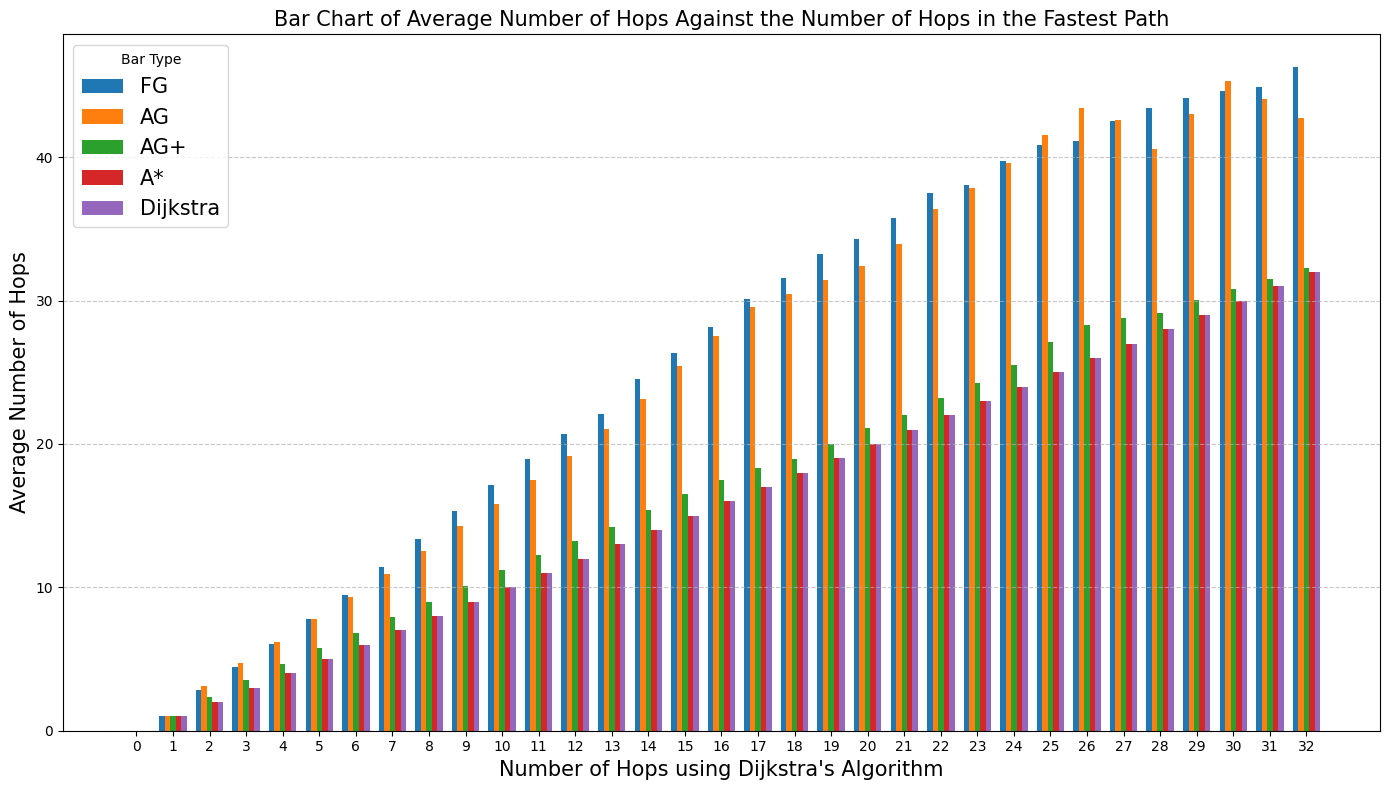

In [167]:
""" 
Graph Plottting:
1. Plotting the average number of extra hops based on the fastest path
2. Plotting the average number of hops against the fastest path number of hops
3. Plot distance of graph in km agaisnt edge density
"""

# This is the first graph
hops_differences = {}
print(len(dg_paths))
for j in range(len(real_top)):
    for i in range(len(dg_paths[f"DG_{j}"])):
        path = dg_paths[f"DG_{j}"][i]
        dg_length = len(path)-1
        hg1_error = len(hg1_paths[f"HG1_{j}"][i])-1
        hg2_error = len(hg2_paths[f"HG2_{j}"][i])-1
        hg3_error = len(hg3_paths[f"HG3_{j}"][i])-1
        a_error = len(astar_paths[f"A_{j}"][i])-1

        if dg_length not in hops_differences:
            hops_differences[dg_length] = [hg1_error, hg2_error, hg3_error, a_error, dg_length, 1]

        else:
            hops_differences[dg_length][0] += hg1_error
            hops_differences[dg_length][1] += hg2_error
            hops_differences[dg_length][2] += hg3_error
            hops_differences[dg_length][3] += a_error
            hops_differences[dg_length][4] += dg_length
            hops_differences[dg_length][5] += 1

for i in hops_differences:
    hops_differences[i][0] /= hops_differences[i][5]
    hops_differences[i][1] /= hops_differences[i][5]
    hops_differences[i][2] /= hops_differences[i][5]
    hops_differences[i][3] /= hops_differences[i][5]
    hops_differences[i][4] /= hops_differences[i][5]

hops_differences = dict(sorted(hops_differences.items()))

for keys in hops_differences.keys():
    print(keys, hops_differences[keys][5])


""" Plot the average number of extra hops against the number of hops in the fastest path (DG) """

# Prepare data for plotting
keys = list(hops_differences.keys())
values = [v[:5] for v in hops_differences.values()]  # Use only the first 5 values per key

# Create the figure
fig, ax = plt.subplots(figsize=(14, 8))

# Define x locations for each group of 5 bars
x = np.arange(len(keys))  # Position of groups on x-axis
bar_width = 0.15  # Width of each bar
num_bars = len(values[0])  # Number of bars per group

# Define custom labels for the legend
labels = ['FG', 'AG', 'AG+', 'A*', "Dijkstra"]

# Plot each of the 5 bars for all keys
for i in range(num_bars):
    bar_positions = x + i * bar_width  # Offset each bar
    bar_values = [v[i] for v in values]
    ax.bar(bar_positions, bar_values, bar_width, label=labels[i])

# Set x-ticks to the middle of the grouped bars
ax.set_xticks(x + bar_width * (num_bars - 1) / 2)
ax.set_xticklabels(keys)

# Add labels, title, and legend
plt.xlabel("Number of Hops using Dijkstra's Algorithm", fontsize=15)
plt.ylabel('Average Number of Hops', fontsize=15)
plt.title('Bar Chart of Average Number of Hops Against the Number of Hops in the Fastest Path', fontsize=15)
plt.legend(title="Bar Type", fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig(f"Graphs Images/Num hops to num hops in fastest path.png", dpi=300)
plt.show()





## This section calculates the average number of **EXTRA** hops for each algorithm compared to Dijkstra Algorithm and then plots a graph of (Average extra hops VS Number of hops in Dijkstra)

105


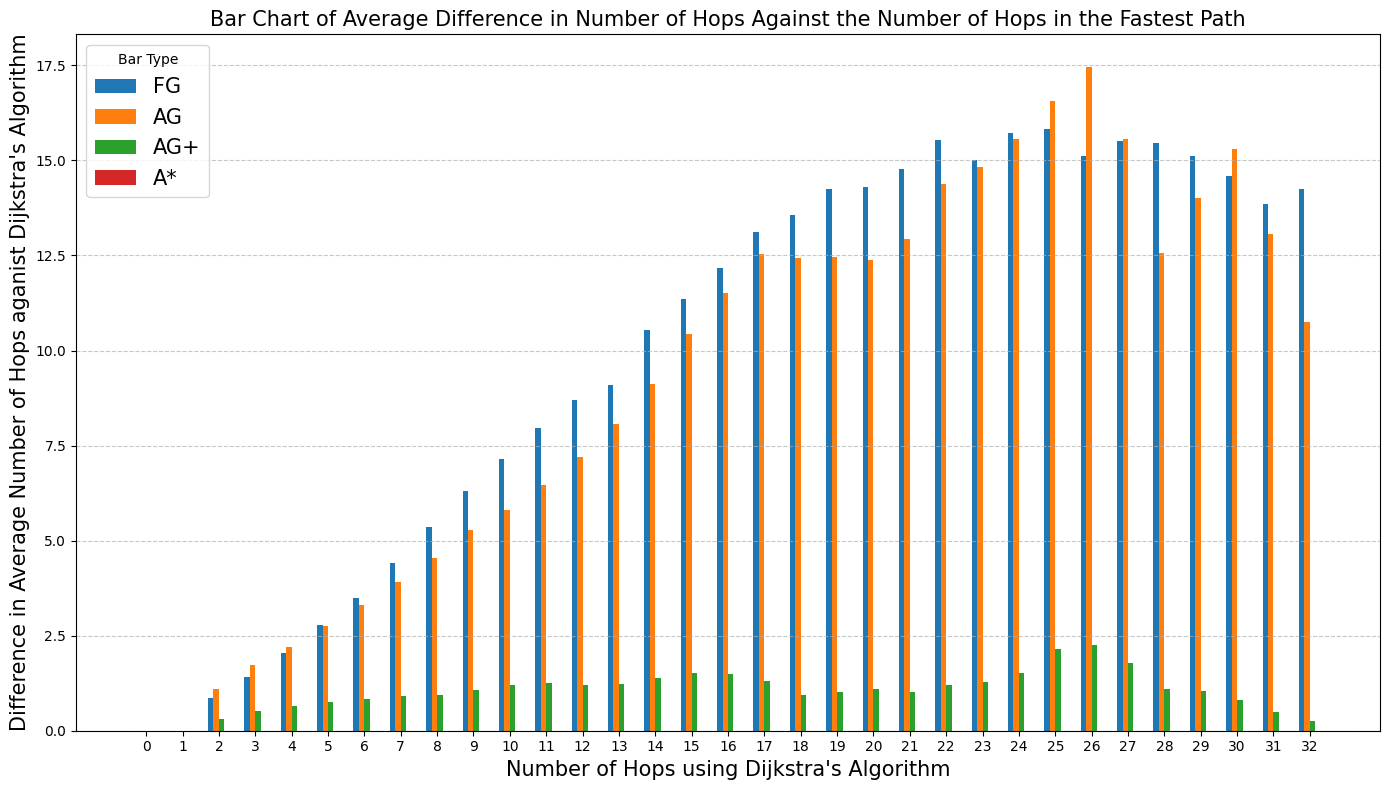

In [168]:
""" 
Graph Plottting:
1. Plotting the average number of extra hops based on the fastest path
2. Plotting the average number of hops against the fastest path number of hops
3. Plot distance of graph in km agaisnt edge density
"""

hops_differences = {}
print(len(dg_paths))


for j in range(len(real_top)):
    for i in range(len(dg_paths[f"DG_{j}"])):
        path = dg_paths[f"DG_{j}"][i]
        dg_length = len(path)-1
        hg1_error = len(hg1_paths[f"HG1_{j}"][i])-1-dg_length
        hg2_error = len(hg2_paths[f"HG2_{j}"][i])-1-dg_length
        hg3_error = len(hg3_paths[f"HG3_{j}"][i])-1-dg_length
        a_error = len(astar_paths[f"A_{j}"][i])-1-dg_length

        if dg_length not in hops_differences:
            hops_differences[dg_length] = [hg1_error, hg2_error, hg3_error, a_error, 1]

        else:
            hops_differences[dg_length][0] += hg1_error
            hops_differences[dg_length][1] += hg2_error
            hops_differences[dg_length][2] += hg3_error
            hops_differences[dg_length][3] += a_error
            hops_differences[dg_length][4] += 1

for i in hops_differences:
    hops_differences[i][0] /= hops_differences[i][4]
    hops_differences[i][1] /= hops_differences[i][4]
    hops_differences[i][2] /= hops_differences[i][4]
    hops_differences[i][3] /= hops_differences[i][4]
    
hops_differences = dict(sorted(hops_differences.items()))


""" Plot the average number of extra hops against the number of hops in the fastest path (DG) """

# Prepare data for plotting
keys = list(hops_differences.keys())
values = [v[:4] for v in hops_differences.values()]  # Use only the first 5 values per key

# Create the figure
fig, ax = plt.subplots(figsize=(14, 8))

# Define x locations for each group of 5 bars
x = np.arange(len(keys))  # Position of groups on x-axis
bar_width = 0.15  # Width of each bar
num_bars = len(values[0])  # Number of bars per group

# Define custom labels for the legend
labels = ['FG', 'AG', 'AG+', 'A*']

# Plot each of the 5 bars for all keys
for i in range(num_bars):
    bar_positions = x + i * bar_width  # Offset each bar
    bar_values = [v[i] for v in values]
    ax.bar(bar_positions, bar_values, bar_width, label=labels[i])

# Set x-ticks to the middle of the grouped bars
ax.set_xticks(x + bar_width * (num_bars - 1) / 2)
ax.set_xticklabels(keys)

# Add labels, title, and legend
plt.xlabel("Number of Hops using Dijkstra's Algorithm", fontsize=15)
plt.ylabel("Difference in Average Number of Hops aganist Dijkstra's Algorithm", fontsize=15)
plt.title('Bar Chart of Average Difference in Number of Hops Against the Number of Hops in the Fastest Path', fontsize=15)
plt.legend(title="Bar Type", fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig(f"Graphs Images/Diff in num hops to num hops in fastest path.png", dpi=300)
plt.show()
hop_diff_all = hops_differences




## CLASS 0: This section calculates the average number of **EXTRA** hops for each algorithm compared to Dijkstra Algorithm and then plots a graph of (Average extra hops VS Number of hops in Dijkstra)

105
[0, 9, 11, 15, 18, 20, 27, 28, 29, 30, 34, 36, 46, 49, 50, 52, 54, 55, 57, 58, 63, 66, 67, 69, 71, 72, 73, 74, 77, 80, 81, 85, 90, 93, 99, 104]


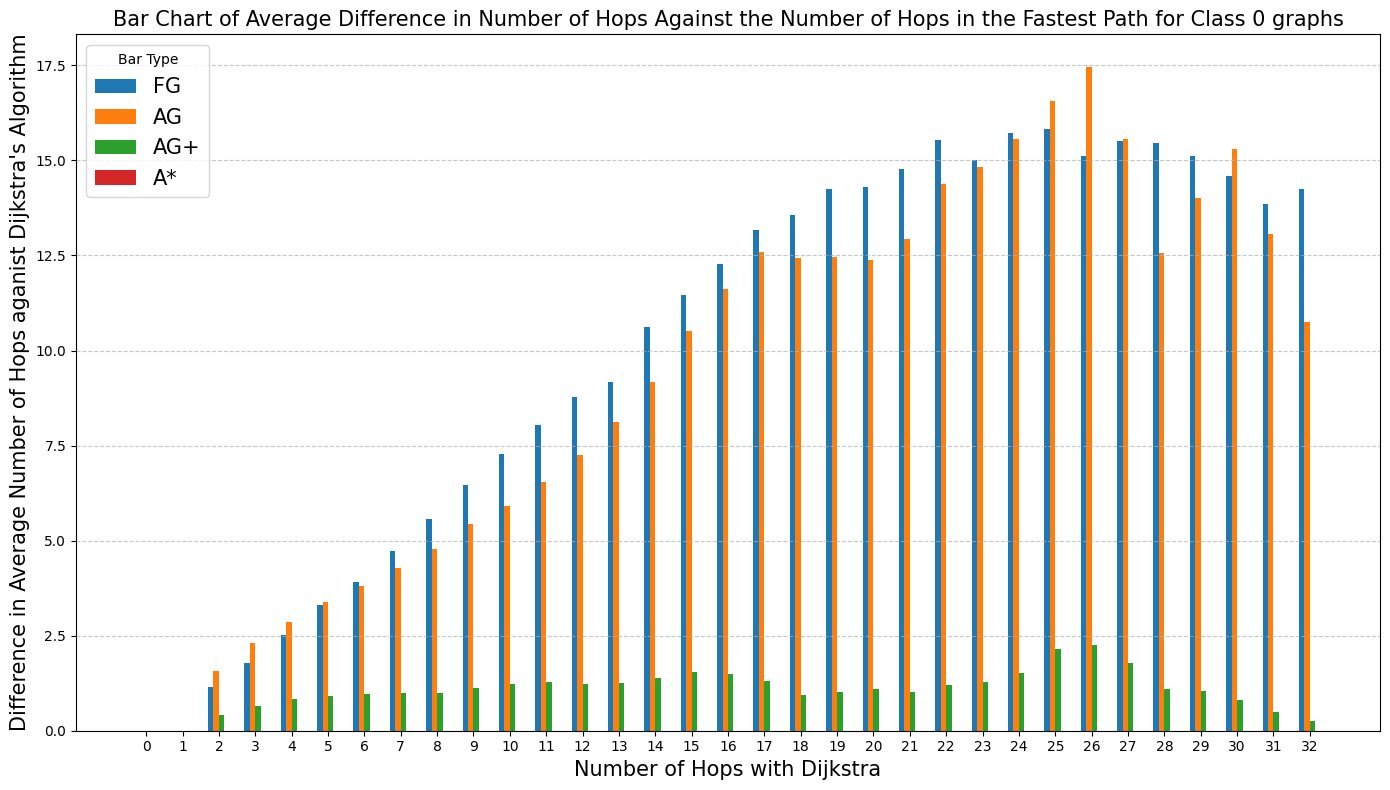

In [169]:
""" 
Graph Plottting:
1. Plotting the average number of extra hops based on the fastest path
2. Plotting the average number of hops against the fastest path number of hops
3. Plot distance of graph in km agaisnt edge density
"""

hops_differences_0 = {}
print(len(dg_paths))
print(graph_class_sorted[0])
res = 0

for j in graph_class_sorted[0]:
    for i in range(len(dg_paths[f"DG_{j}"])):
        path = dg_paths[f"DG_{j}"][i]
        dg_length = len(path)-1
        hg1_error = len(hg1_paths[f"HG1_{j}"][i])-1-dg_length
        hg2_error = len(hg2_paths[f"HG2_{j}"][i])-1-dg_length
        hg3_error = len(hg3_paths[f"HG3_{j}"][i])-1-dg_length
        a_error = len(astar_paths[f"A_{j}"][i])-1-dg_length

        if dg_length not in hops_differences_0:
            hops_differences_0[dg_length] = [hg1_error, hg2_error, hg3_error, a_error, 1]

        else:
            hops_differences_0[dg_length][0] += hg1_error
            hops_differences_0[dg_length][1] += hg2_error
            hops_differences_0[dg_length][2] += hg3_error
            hops_differences_0[dg_length][3] += a_error
            hops_differences_0[dg_length][4] += 1

for i in hops_differences_0:
    hops_differences_0[i][0] /= hops_differences_0[i][4]
    hops_differences_0[i][1] /= hops_differences_0[i][4]
    hops_differences_0[i][2] /= hops_differences_0[i][4]
    hops_differences_0[i][3] /= hops_differences_0[i][4]
    
hops_differences_0 = dict(sorted(hops_differences_0.items()))

""" Plot the average number of extra hops against the number of hops in the fastest path (DG) """

# Prepare data for plotting
keys = list(hops_differences_0.keys())
values = [v[:4] for v in hops_differences_0.values()]  # Use only the first 5 values per key

# Create the figure
fig, ax = plt.subplots(figsize=(14, 8))

# Define x locations for each group of 5 bars
x = np.arange(len(keys))  # Position of groups on x-axis
bar_width = 0.15  # Width of each bar
num_bars = len(values[0])  # Number of bars per group

# Define custom labels for the legend
labels = ['FG', 'AG', 'AG+', 'A*']

# Plot each of the 5 bars for all keys
for i in range(num_bars):
    bar_positions = x + i * bar_width  # Offset each bar
    bar_values = [v[i] for v in values]
    ax.bar(bar_positions, bar_values, bar_width, label=labels[i])

# Set x-ticks to the middle of the grouped bars
ax.set_xticks(x + bar_width * (num_bars - 1) / 2)
ax.set_xticklabels(keys)

# Add labels, title, and legend
plt.xlabel('Number of Hops with Dijkstra', fontsize=15)
plt.ylabel("Difference in Average Number of Hops aganist Dijkstra's Algorithm", fontsize=15)
plt.title('Bar Chart of Average Difference in Number of Hops Against the Number of Hops in the Fastest Path for Class 0 graphs', fontsize=15)
plt.legend(title="Bar Type", fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig(f"Graphs Images/Class 0 - Diff in num of hops against num hops in fastest path.png", dpi=300)
plt.show()



## CLASS 1: This section calculates the average number of **EXTRA** hops for each algorithm compared to Dijkstra Algorithm and then plots a graph of (Average extra hops VS Number of hops in Dijkstra)

105
18


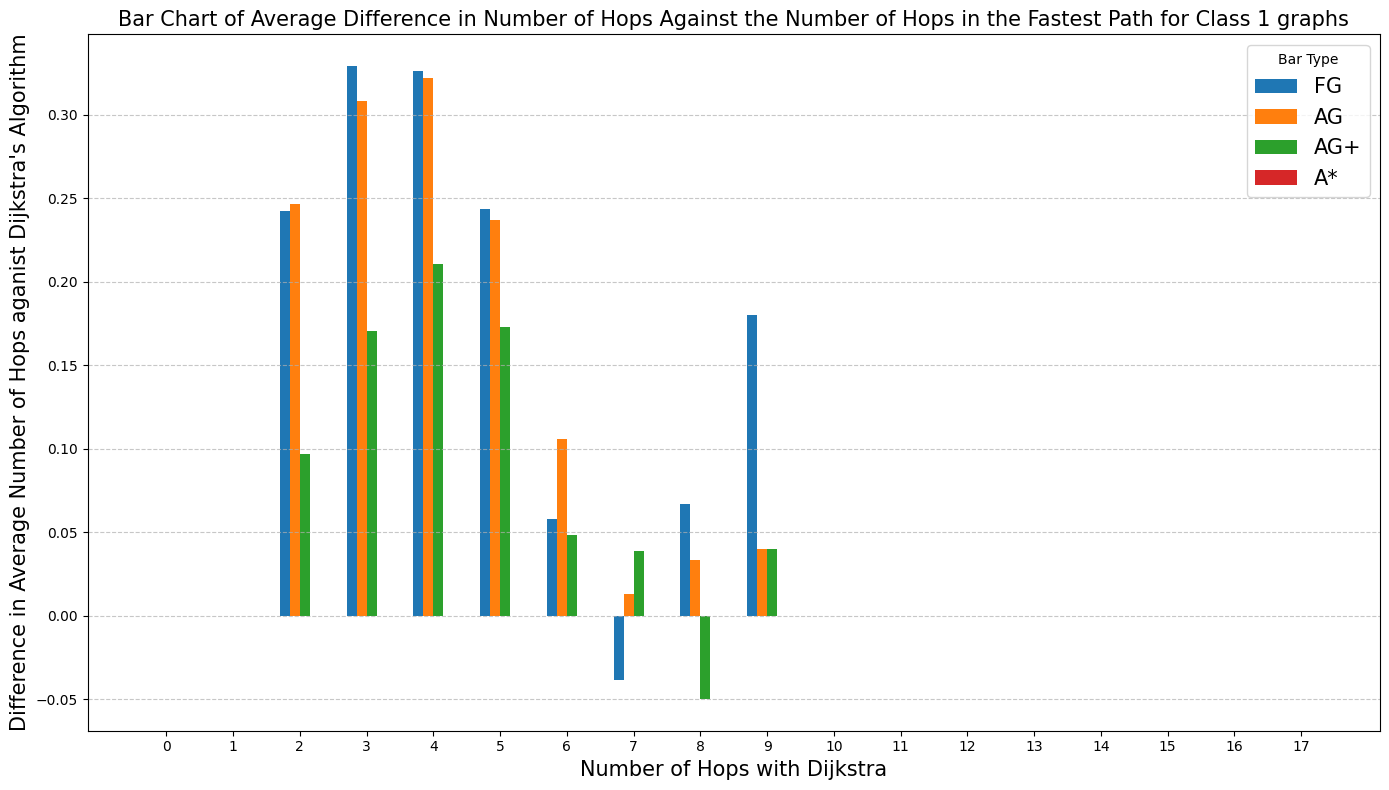

In [170]:
""" 
Graph Plottting:
1. Plotting the average number of extra hops based on the fastest path
2. Plotting the average number of hops against the fastest path number of hops
3. Plot distance of graph in km agaisnt edge density
"""

hops_differences = {}
print(len(dg_paths))
print(len(graph_class_sorted[1]))
res = 0


for j in graph_class_sorted[1]:
    for i in range(len(dg_paths[f"DG_{j}"])):
        path = dg_paths[f"DG_{j}"][i]
        dg_length = len(path)-1
        hg1_error = len(hg1_paths[f"HG1_{j}"][i])-1-dg_length
        hg2_error = len(hg2_paths[f"HG2_{j}"][i])-1-dg_length
        hg3_error = len(hg3_paths[f"HG3_{j}"][i])-1-dg_length
        a_error = len(astar_paths[f"A_{j}"][i])-1-dg_length

        if dg_length not in hops_differences:
            hops_differences[dg_length] = [hg1_error, hg2_error, hg3_error, a_error, 1]

        else:
            hops_differences[dg_length][0] += hg1_error
            hops_differences[dg_length][1] += hg2_error
            hops_differences[dg_length][2] += hg3_error
            hops_differences[dg_length][3] += a_error
            hops_differences[dg_length][4] += 1

for i in hops_differences:
    hops_differences[i][0] /= hops_differences[i][4]
    hops_differences[i][1] /= hops_differences[i][4]
    hops_differences[i][2] /= hops_differences[i][4]
    hops_differences[i][3] /= hops_differences[i][4]

hops_differences = dict(sorted(hops_differences.items()))


""" Plot the average number of extra hops against the number of hops in the fastest path (DG) """

# Prepare data for plotting
keys = list(hops_differences.keys())
values = [v[:4] for v in hops_differences.values()]  # Use only the first 5 values per key

# Create the figure
fig, ax = plt.subplots(figsize=(14, 8))

# Define x locations for each group of 5 bars
x = np.arange(len(keys))  # Position of groups on x-axis
bar_width = 0.15  # Width of each bar
num_bars = len(values[0])  # Number of bars per group

# Define custom labels for the legend
labels = ['FG', 'AG', 'AG+', 'A*']

# Plot each of the 5 bars for all keys
for i in range(num_bars):
    bar_positions = x + i * bar_width  # Offset each bar
    bar_values = [v[i] for v in values]
    ax.bar(bar_positions, bar_values, bar_width, label=labels[i])

# Set x-ticks to the middle of the grouped bars
ax.set_xticks(x + bar_width * (num_bars - 1) / 2)
ax.set_xticklabels(keys)

# Add labels, title, and legend
plt.xlabel('Number of Hops with Dijkstra', fontsize=15)
plt.ylabel("Difference in Average Number of Hops aganist Dijkstra's Algorithm", fontsize=15)
plt.title('Bar Chart of Average Difference in Number of Hops Against the Number of Hops in the Fastest Path for Class 1 graphs', fontsize=15)
plt.legend(title="Bar Type", fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig(f"Graphs Images/Class 1 - Diff in num of hops against num hops in fastest path.png", dpi=300)
plt.show()





## CLASS 2: This section calculates the average number of **EXTRA** hops for each algorithm compared to Dijkstra Algorithm and then plots a graph of (Average extra hops VS Number of hops in Dijkstra)

105


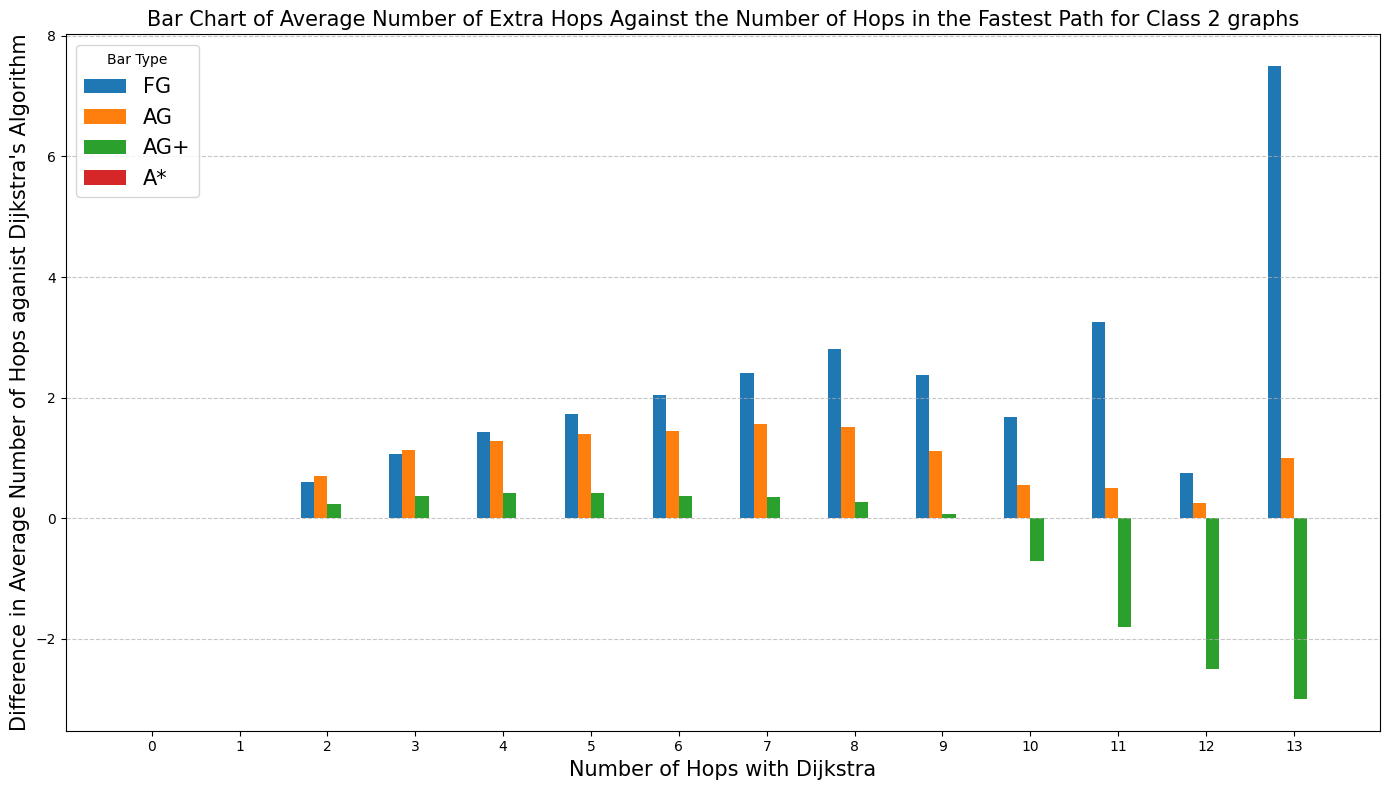

In [171]:
""" 
Graph Plottting:
1. Plotting the average number of extra hops based on the fastest path
2. Plotting the average number of hops against the fastest path number of hops
3. Plot distance of graph in km agaisnt edge density
"""

hops_differences = {}
print(len(dg_paths))

for j in graph_class_sorted[2]:
    for i in range(len(dg_paths[f"DG_{j}"])):
        path = dg_paths[f"DG_{j}"][i]
        dg_length = len(path)-1
        hg1_error = len(hg1_paths[f"HG1_{j}"][i])-1-dg_length
        hg2_error = len(hg2_paths[f"HG2_{j}"][i])-1-dg_length
        hg3_error = len(hg3_paths[f"HG3_{j}"][i])-1-dg_length
        a_error = len(astar_paths[f"A_{j}"][i])-1-dg_length

        if dg_length not in hops_differences:
            hops_differences[dg_length] = [hg1_error, hg2_error, hg3_error, a_error, 1]

        else:
            hops_differences[dg_length][0] += hg1_error
            hops_differences[dg_length][1] += hg2_error
            hops_differences[dg_length][2] += hg3_error
            hops_differences[dg_length][3] += a_error
            hops_differences[dg_length][4] += 1

for i in hops_differences:
    hops_differences[i][0] /= hops_differences[i][4]
    hops_differences[i][1] /= hops_differences[i][4]
    hops_differences[i][2] /= hops_differences[i][4]
    hops_differences[i][3] /= hops_differences[i][4]

hops_differences = dict(sorted(hops_differences.items()))


""" Plot the average number of extra hops against the number of hops in the fastest path (DG) """

# Prepare data for plotting
keys = list(hops_differences.keys())
values = [v[:4] for v in hops_differences.values()]  # Use only the first 5 values per key

# Create the figure
fig, ax = plt.subplots(figsize=(14, 8))

# Define x locations for each group of 5 bars
x = np.arange(len(keys))  # Position of groups on x-axis
bar_width = 0.15  # Width of each bar
num_bars = len(values[0])  # Number of bars per group

# Define custom labels for the legend
labels = ['FG', 'AG', 'AG+', 'A*']

# Plot each of the 5 bars for all keys
for i in range(num_bars):
    bar_positions = x + i * bar_width  # Offset each bar
    bar_values = [v[i] for v in values]
    ax.bar(bar_positions, bar_values, bar_width, label=labels[i])

# Set x-ticks to the middle of the grouped bars
ax.set_xticks(x + bar_width * (num_bars - 1) / 2)
ax.set_xticklabels(keys)

# Add labels, title, and legend
plt.xlabel('Number of Hops with Dijkstra', fontsize=15)
plt.ylabel("Difference in Average Number of Hops aganist Dijkstra's Algorithm", fontsize=15)
plt.title('Bar Chart of Average Number of Extra Hops Against the Number of Hops in the Fastest Path for Class 2 graphs', fontsize=15)
plt.legend(title="Bar Type", fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig(f"Graphs Images/Class 2 - Diff in num of hops against num hops in fastest path.png", dpi=300)
plt.show()




## This section calculates the total **euclidean distance** between each point that the algorithm finds, and then plots a graph of distance shortest distance found, sorted by class

105


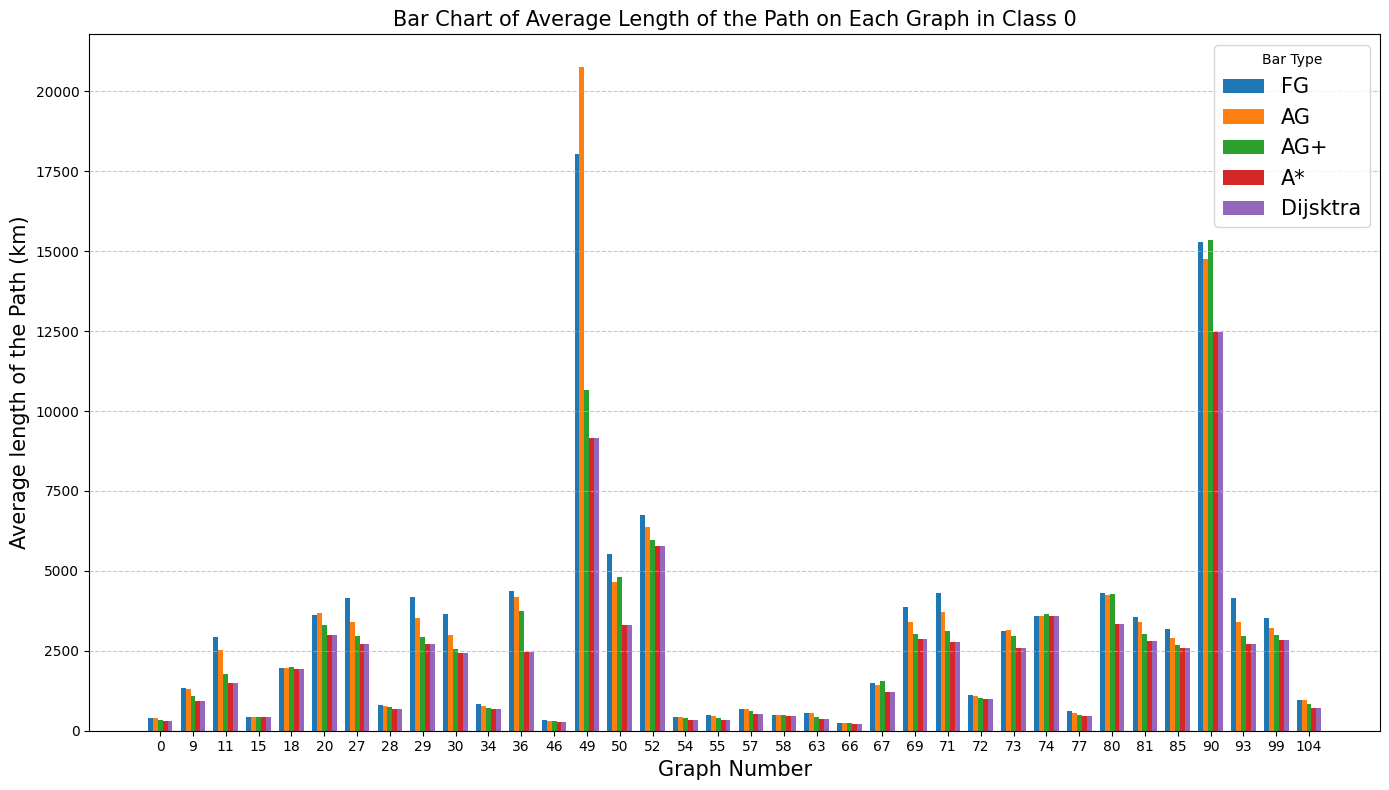

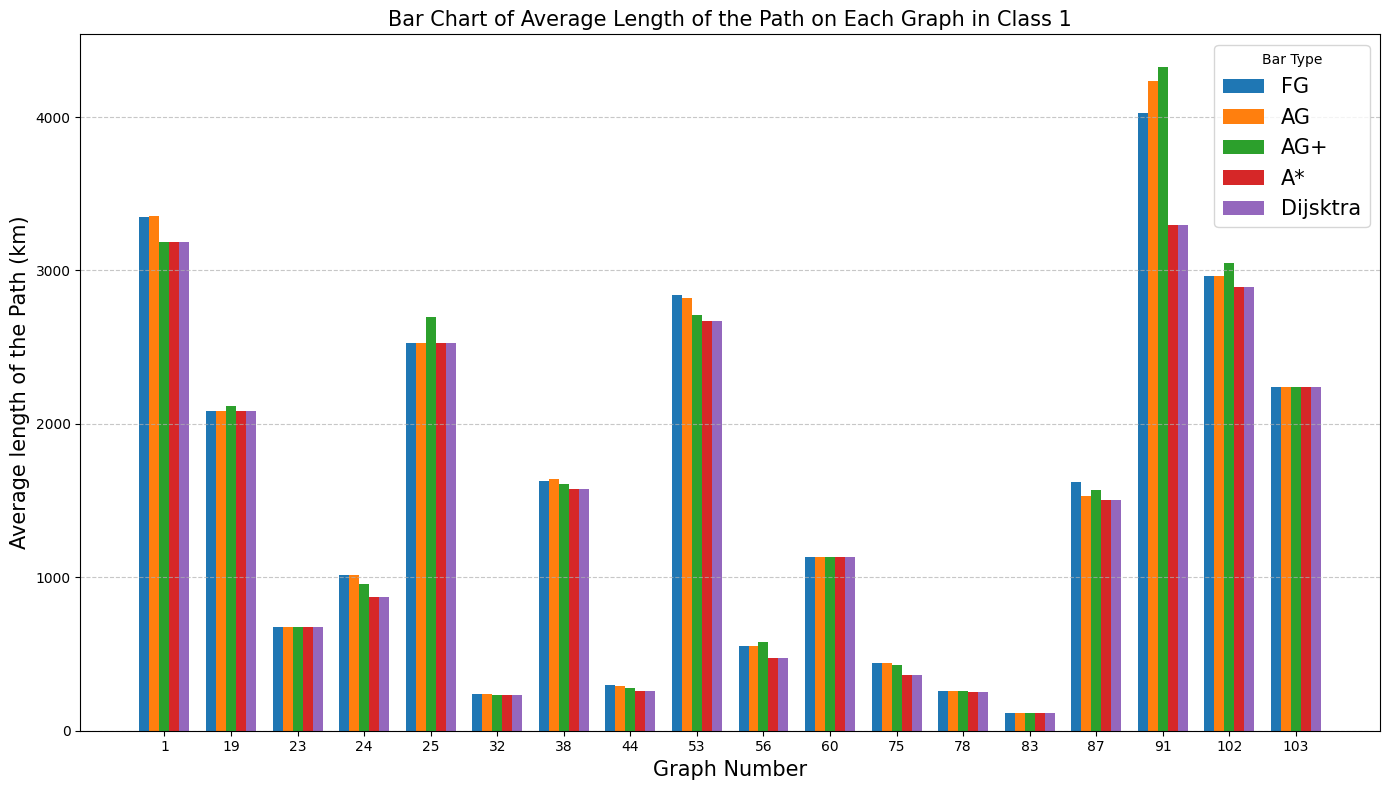

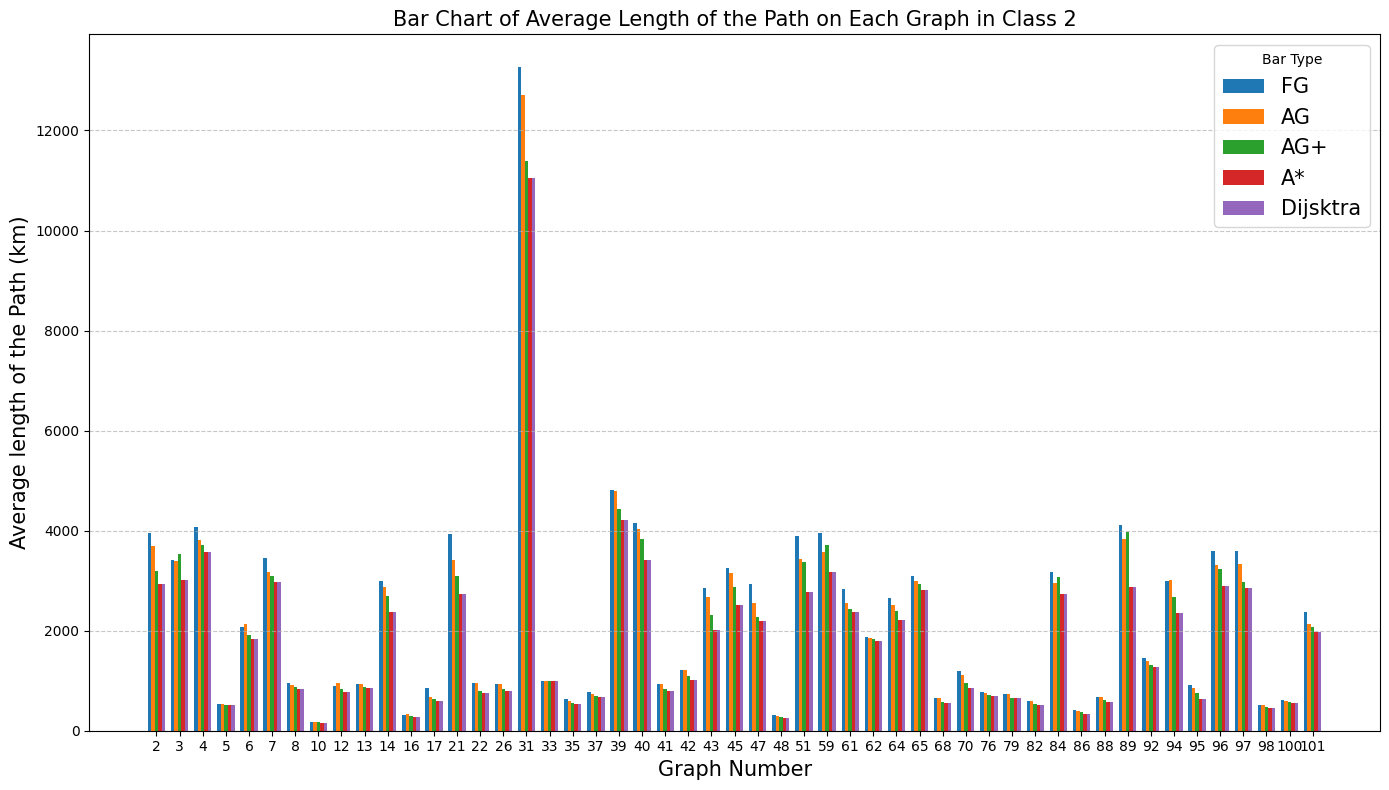

In [172]:
"""Write code here"""

""" 
Graph Plottting:
1. Plotting the average number of extra hops based on the fastest path
2. Plotting the average number of hops against the fastest path number of hops
3. Plot distance of graph in km agaisnt edge density
"""

# This is the first graph
path_length = {}
print(len(dg_paths))
for graph in range(len(real_top)):
    for paths in range(len(dg_paths[f"DG_{graph}"])):
        hg1_path = CalculateError.path_length(hg1_paths[f"HG1_{graph}"][paths], graphs[f"G{graph}_pos"])
        hg2_path = CalculateError.path_length(hg2_paths[f"HG2_{graph}"][paths], graphs[f"G{graph}_pos"])
        hg3_path = CalculateError.path_length(hg3_paths[f"HG3_{graph}"][paths], graphs[f"G{graph}_pos"])
        a_path = CalculateError.path_length(astar_paths[f"A_{graph}"][paths], graphs[f"G{graph}_pos"])
        dg_path = CalculateError.path_length(dg_paths[f"DG_{graph}"][paths], graphs[f"G{graph}_pos"])



        if graph not in path_length:
            path_length[graph] = [hg1_path, hg2_path, hg3_path, a_path ,dg_path, 1]

        else:
            path_length[graph][0] += hg1_path
            path_length[graph][1] += hg2_path
            path_length[graph][2] += hg3_path
            path_length[graph][3] += a_path
            path_length[graph][4] += dg_path
            path_length[graph][5] += 1

for i in path_length:
    for j in range(5):
        path_length[i][j] /= (path_length[i][-1]*1000)


path_length_0 = {}
path_length_1 = {}
path_length_2 = {}
for i in graph_class_sorted[0]:
    path_length_0[i] = path_length[i]
for i in graph_class_sorted[1]:
    path_length_1[i] = path_length[i]
for i in graph_class_sorted[2]:
    path_length_2[i] = path_length[i]




""" Plot the average length of the paths for each algorithm on each graph for class 0"""


# Prepare data for plotting
keys = list(path_length_0.keys())
values = [v[:5] for v in path_length_0.values()]  # Use only the first 5 values per key

# Create the figure
fig, ax = plt.subplots(figsize=(14, 8))

# Define x locations for each group of bars
x = np.arange(len(keys))  # Position of groups on x-axis
bar_width = 0.15  # Width of each bar
num_bars = len(values[0])  # Number of bars per group

# Define custom labels for the legend
labels = ['FG', 'AG', 'AG+', 'A*', "Dijsktra"]

# Plot each of the 4 bars for all keys
for i in range(num_bars):
    bar_positions = x + i * bar_width  # Offset each bar
    bar_values = [v[i] for v in values]
    ax.bar(bar_positions, bar_values, bar_width, label=labels[i])

# Set x-ticks to the middle of the grouped bars
ax.set_xticks(x + bar_width * (num_bars - 1) / 2)
ax.set_xticklabels(keys)

# Add labels, title, and legend
plt.xlabel('Graph Number', fontsize=15)
plt.ylabel('Average length of the Path (km)', fontsize=15)
plt.title('Bar Chart of Average Length of the Path on Each Graph in Class 0', fontsize=15)
plt.legend(title="Bar Type", fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig(f"Graphs Images/Class 0 - Av. len of each path for each graph.png", dpi=300)

plt.show()

""" Plot the average length of the paths for each algorithm on each graph for class 1"""

# Prepare data for plotting
keys = list(path_length_1.keys())
values = [v[:5] for v in path_length_1.values()]  # Use only the first 5 values per key

# Create the figure
fig, ax = plt.subplots(figsize=(14, 8))

# Define x locations for each group of bars
x = np.arange(len(keys))  # Position of groups on x-axis
bar_width = 0.15  # Width of each bar
num_bars = len(values[0])  # Number of bars per group

# Define custom labels for the legend
labels = ['FG', 'AG', 'AG+', 'A*', "Dijsktra"]

# Plot each of the 4 bars for all keys
for i in range(num_bars):
    bar_positions = x + i * bar_width  # Offset each bar
    bar_values = [v[i] for v in values]
    ax.bar(bar_positions, bar_values, bar_width, label=labels[i])

# Set x-ticks to the middle of the grouped bars
ax.set_xticks(x + bar_width * (num_bars - 1) / 2)
ax.set_xticklabels(keys)

# Add labels, title, and legend
plt.xlabel('Graph Number', fontsize=15)
plt.ylabel('Average length of the Path (km)', fontsize=15)
plt.title('Bar Chart of Average Length of the Path on Each Graph in Class 1', fontsize=15)
plt.legend(title="Bar Type", fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig(f"Graphs Images/Class 1 - Av. len of each path for each graph.png", dpi=300)
plt.show()

""" Plot the average length of the paths for each algorithm on each graph for class 2 """

# Prepare data for plotting
keys = list(path_length_2.keys())
values = [v[:5] for v in path_length_2.values()]  # Use only the first 5 values per key

# Create the figure
fig, ax = plt.subplots(figsize=(14, 8))

# Define x locations for each group of bars
x = np.arange(len(keys))  # Position of groups on x-axis
bar_width = 0.15  # Width of each bar
num_bars = len(values[0])  # Number of bars per group

# Define custom labels for the legend
labels = ['FG', 'AG', 'AG+', 'A*', "Dijsktra"]

# Plot each of the 4 bars for all keys
for i in range(num_bars):
    bar_positions = x + i * bar_width  # Offset each bar
    bar_values = [v[i] for v in values]
    ax.bar(bar_positions, bar_values, bar_width, label=labels[i])

# Set x-ticks to the middle of the grouped bars
ax.set_xticks(x + bar_width * (num_bars - 1) / 2)
ax.set_xticklabels(keys)

# Add labels, title, and legend
plt.xlabel('Graph Number', fontsize=15)
plt.ylabel('Average length of the Path (km)', fontsize=15)
plt.title('Bar Chart of Average Length of the Path on Each Graph in Class 2', fontsize=15)
plt.legend(title="Bar Type", fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig(f"Graphs Images/Class 2 - Av. len of each path for each graph.png", dpi=300)
plt.show()


## Shows the average cpu time necessary to calculate all paths for each algorithm, sorted by number of hops

0 2738
1 7196
2 11648
3 14150
4 13662
5 11912
6 9862
7 8224
8 6782
9 5610
10 4574
11 3728
12 3002
13 2348
14 1804
15 1424
16 1134
17 922
18 750
19 630
20 532
21 442
22 322
23 232
24 150
25 110
26 90
27 66
28 40
29 24
30 20
31 14
32 4


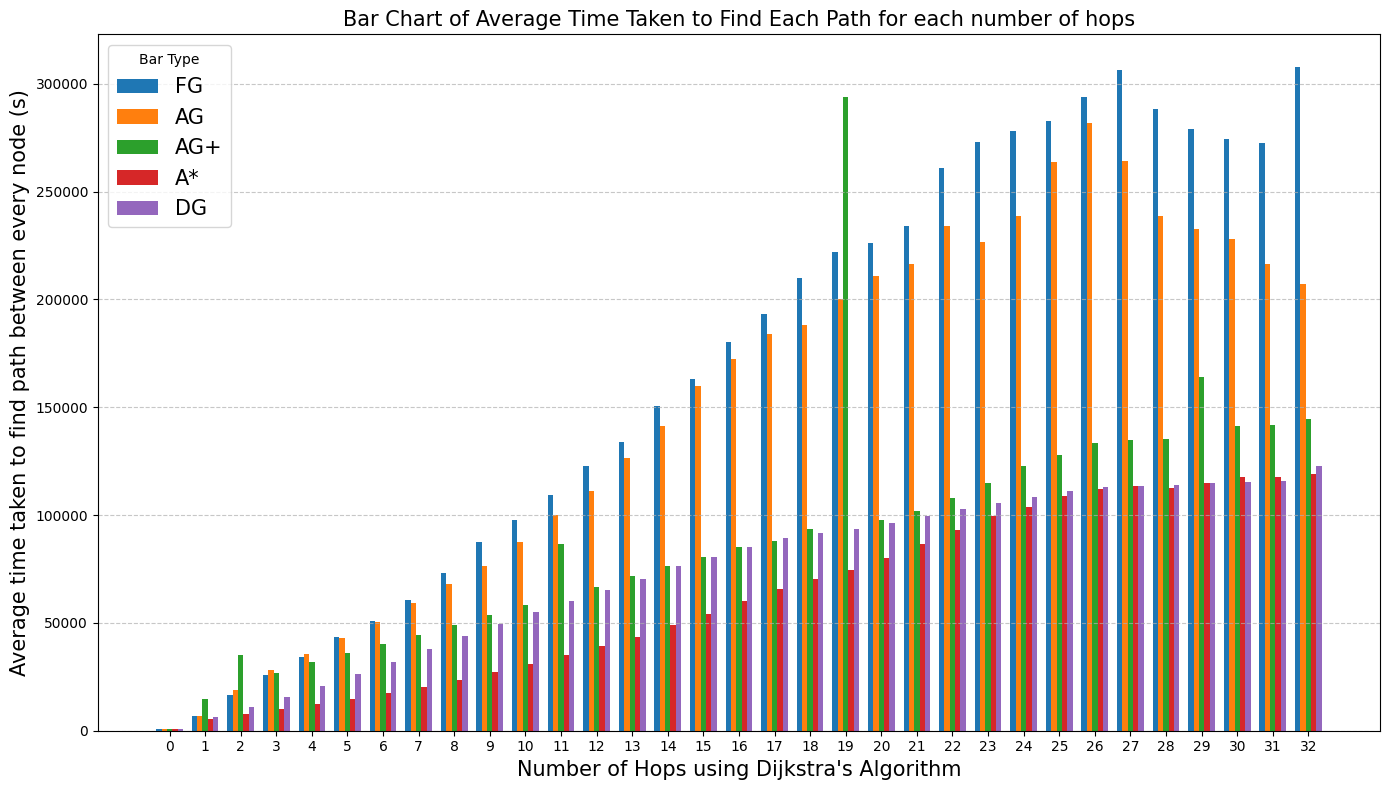

In [173]:
""" 
Graph Plottting:
1. Plotting the average number of extra hops based on the fastest path
2. Plotting the average number of hops against the fastest path number of hops
3. Plot distance of graph in km agaisnt edge density
"""

cpu_time_by_hops = {}

for j in range(len(real_top)):
    for i in range(len(dg_paths[f"DG_{j}"])):
        dg_length = len(dg_paths[f"DG_{j}"][i])-1
        hg1_time, hg2_time, hg3_time, a_time, dg_time  = cpu_time[f"CPU_{j}"][i][0], cpu_time[f"CPU_{j}"][i][1], cpu_time[f"CPU_{j}"][i][2], cpu_time[f"CPU_{j}"][i][3], cpu_time[f"CPU_{j}"][i][4]

        if dg_length not in cpu_time_by_hops:
            cpu_time_by_hops[dg_length] = [hg1_time, hg2_time, hg3_time, a_time, dg_time, 1]

        else:
            cpu_time_by_hops[dg_length][0] += hg1_time
            cpu_time_by_hops[dg_length][1] += hg2_time
            cpu_time_by_hops[dg_length][2] += hg3_time
            cpu_time_by_hops[dg_length][3] += a_time
            cpu_time_by_hops[dg_length][4] += dg_time
            cpu_time_by_hops[dg_length][5] += 1

for i in cpu_time_by_hops:
    for j in range(5):
        cpu_time_by_hops[i][j] /= cpu_time_by_hops[i][5]
    
cpu_time_by_hops = dict(sorted(cpu_time_by_hops.items()))

for keys in cpu_time_by_hops.keys():
    print(keys, cpu_time_by_hops[keys][5])

""" Plot the average number of extra hops against the number of hops in the fastest path (DG) """

# Prepare data for plotting
keys = list(cpu_time_by_hops.keys())
values = [v[:5] for v in cpu_time_by_hops.values()]  # Use only the first 5 values per key

# Create the figure
fig, ax = plt.subplots(figsize=(14, 8))

# Define x locations for each group of 5 bars
x = np.arange(len(keys))  # Position of groups on x-axis
bar_width = 0.15  # Width of each bar
num_bars = len(values[0])  # Number of bars per group

# Define custom labels for the legend
labels = ['FG', 'AG', 'AG+', 'A*', "DG"]

# Plot each of the 5 bars for all keys
for i in range(num_bars):
    bar_positions = x + i * bar_width  # Offset each bar
    bar_values = [v[i] for v in values]
    ax.bar(bar_positions, bar_values, bar_width, label=labels[i])

# Set x-ticks to the middle of the grouped bars
ax.set_xticks(x + bar_width * (num_bars - 1) / 2)
ax.set_xticklabels(keys)

# Add labels, title, and legend
plt.xlabel("Number of Hops using Dijkstra's Algorithm", fontsize=15)
plt.ylabel('Average time taken to find path between every node (s)', fontsize=15)
plt.title('Bar Chart of Average Time Taken to Find Each Path for each number of hops', fontsize=15)
plt.legend(title="Bar Type", fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig(f"Graphs Images/Av. time taken fo each path against num of hops.png", dpi=300)
plt.show()

## Shows the average cpu time to calculate each path for each graph sorted by classes

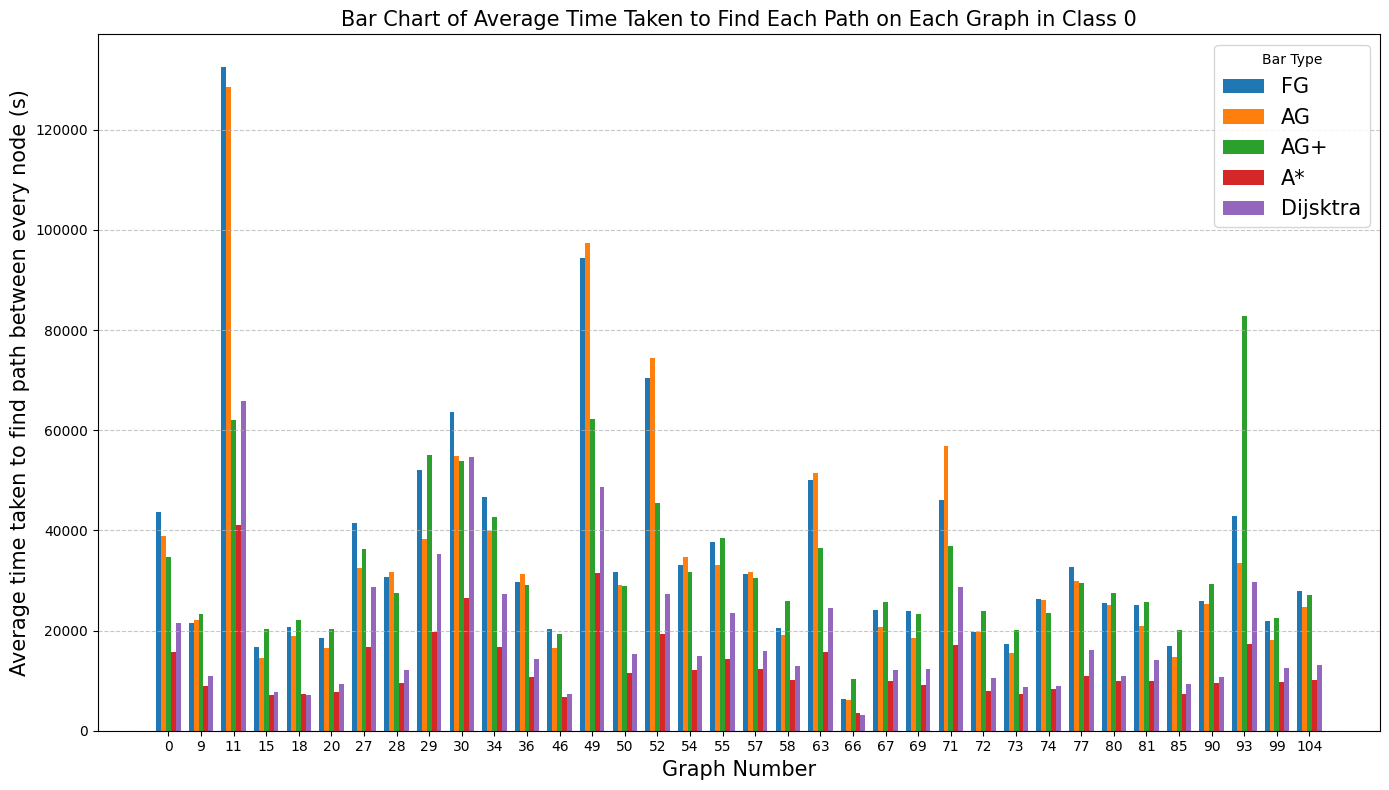

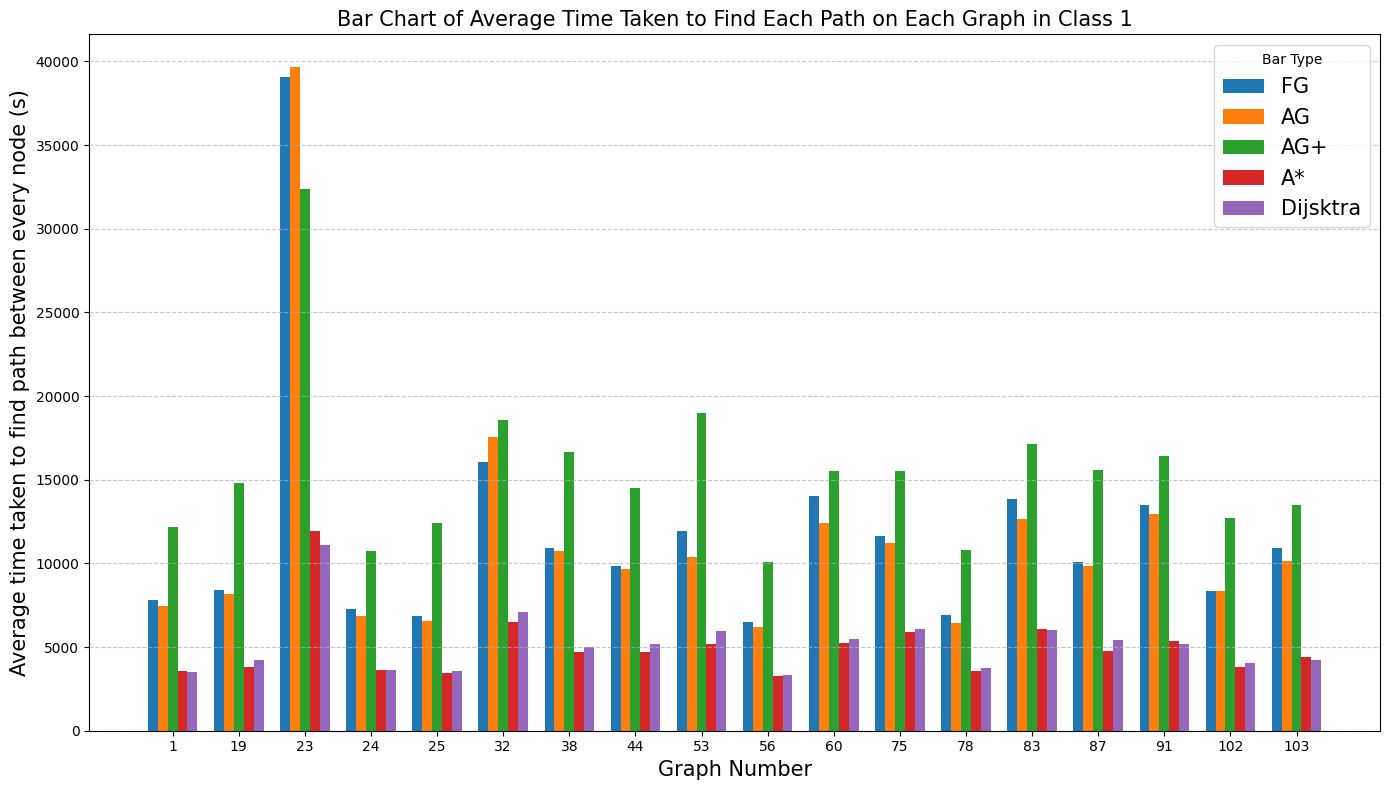

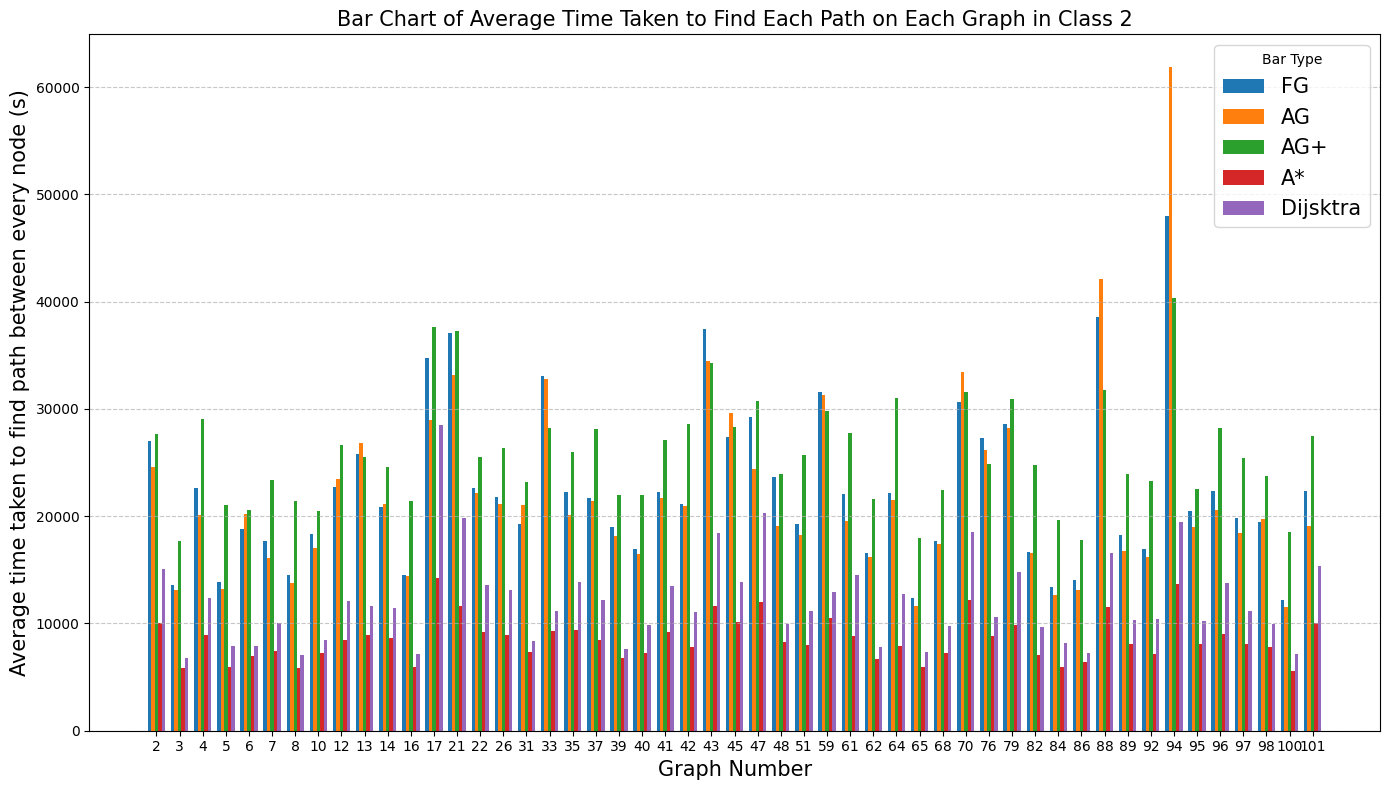

In [174]:
"""Write code here"""

""" 
Graph Plottting:
1. Plotting the average number of extra hops based on the fastest path
2. Plotting the average number of hops against the fastest path number of hops
3. Plot distance of graph in km agaisnt edge density
"""

cpu_time_by_hops = {}

for graph in range(len(real_top)):
    for i in range(len(cpu_time[f"CPU_{graph}"])):
        hg1_time, hg2_time, hg3_time, a_time, dg_time = cpu_time[f"CPU_{graph}"][i][0], cpu_time[f"CPU_{graph}"][i][1], cpu_time[f"CPU_{graph}"][i][2], cpu_time[f"CPU_{graph}"][i][3], cpu_time[f"CPU_{graph}"][i][4]

        if graph not in cpu_time_by_hops:
            cpu_time_by_hops[graph] = [hg1_time, hg2_time, hg3_time, a_time, dg_time, 1]

        else:
            cpu_time_by_hops[graph][0] += hg1_time
            cpu_time_by_hops[graph][1] += hg2_time
            cpu_time_by_hops[graph][2] += hg3_time
            cpu_time_by_hops[graph][3] += a_time
            cpu_time_by_hops[graph][4] += dg_time
            cpu_time_by_hops[graph][5] += 1

for i in cpu_time_by_hops:
    for j in range(5):
        cpu_time_by_hops[i][j] /= cpu_time_by_hops[i][5]
    
cpu_time_by_hops = dict(sorted(cpu_time_by_hops.items()))


cpu_time_0 = {}
cpu_time_1 = {}
cpu_time_2 = {}
for i in graph_class_sorted[0]:
    cpu_time_0[i] = cpu_time_by_hops[i]
for i in graph_class_sorted[1]:
    cpu_time_1[i] = cpu_time_by_hops[i]
for i in graph_class_sorted[2]:
    cpu_time_2[i] = cpu_time_by_hops[i]




""" Plot the average time taken to find each of the paths for each algorithm on each graph for class 0"""


# Prepare data for plotting
keys = list(cpu_time_0.keys())
values = [v[:5] for v in cpu_time_0.values()]  # Use only the first 5 values per key

# Create the figure
fig, ax = plt.subplots(figsize=(14, 8))

# Define x locations for each group of bars
x = np.arange(len(keys))  # Position of groups on x-axis
bar_width = 0.15  # Width of each bar
num_bars = len(values[0])  # Number of bars per group

# Define custom labels for the legend
labels = ['FG', 'AG', 'AG+', 'A*', "Dijsktra"]

# Plot each of the 4 bars for all keys
for i in range(num_bars):
    bar_positions = x + i * bar_width  # Offset each bar
    bar_values = [v[i] for v in values]
    ax.bar(bar_positions, bar_values, bar_width, label=labels[i])

# Set x-ticks to the middle of the grouped bars
ax.set_xticks(x + bar_width * (num_bars - 1) / 2)
ax.set_xticklabels(keys)

# Add labels, title, and legend
plt.xlabel('Graph Number', fontsize=15)
plt.ylabel('Average time taken to find path between every node (s)', fontsize=15)
plt.title('Bar Chart of Average Time Taken to Find Each Path on Each Graph in Class 0', fontsize=15)
plt.legend(title="Bar Type", fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig(f"Graphs Images/Class 0 - Av. time taken fo each path against num of hops.png", dpi=300)
plt.show()

""" Plot the average length of the paths for each algorithm on each graph for class 1"""

# Prepare data for plotting
keys = list(cpu_time_1.keys())
values = [v[:5] for v in cpu_time_1.values()]  # Use only the first 5 values per key

# Create the figure
fig, ax = plt.subplots(figsize=(14, 8))

# Define x locations for each group of bars
x = np.arange(len(keys))  # Position of groups on x-axis
bar_width = 0.15  # Width of each bar   
num_bars = len(values[0])  # Number of bars per group

# Define custom labels for the legend
labels = ['FG', 'AG', 'AG+', 'A*', "Dijsktra"]

# Plot each of the 4 bars for all keys
for i in range(num_bars):
    bar_positions = x + i * bar_width  # Offset each bar
    bar_values = [v[i] for v in values]
    ax.bar(bar_positions, bar_values, bar_width, label=labels[i])

# Set x-ticks to the middle of the grouped bars
ax.set_xticks(x + bar_width * (num_bars - 1) / 2)
ax.set_xticklabels(keys)

# Add labels, title, and legend
plt.xlabel('Graph Number', fontsize=15)
plt.ylabel('Average time taken to find path between every node (s)', fontsize=15)
plt.title('Bar Chart of Average Time Taken to Find Each Path on Each Graph in Class 1', fontsize=15)
plt.legend(title="Bar Type", fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig(f"Graphs Images/Class 1 - Av. time taken fo each path against num of hops.png", dpi=300)
plt.show()

""" Plot the average length of the paths for each algorithm on each graph for class 2 """

# Prepare data for plotting
keys = list(cpu_time_2.keys())
values = [v[:5] for v in cpu_time_2.values()]  # Use only the first 5 values per key

# Create the figure
fig, ax = plt.subplots(figsize=(14, 8))

# Define x locations for each group of bars
x = np.arange(len(keys))  # Position of groups on x-axis
bar_width = 0.15  # Width of each bar
num_bars = len(values[0])  # Number of bars per group

# Define custom labels for the legend
labels = ['FG', 'AG', 'AG+', 'A*', "Dijsktra"]

# Plot each of the 4 bars for all keys
for i in range(num_bars):
    bar_positions = x + i * bar_width  # Offset each bar
    bar_values = [v[i] for v in values]
    ax.bar(bar_positions, bar_values, bar_width, label=labels[i])

# Set x-ticks to the middle of the grouped bars
ax.set_xticks(x + bar_width * (num_bars - 1) / 2)
ax.set_xticklabels(keys)

# Add labels, title, and legend
plt.xlabel('Graph Number', fontsize=15)
plt.ylabel('Average time taken to find path between every node (s)', fontsize=15)
plt.title('Bar Chart of Average Time Taken to Find Each Path on Each Graph in Class 2', fontsize=15)
plt.legend(title="Bar Type", fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig(f"Graphs Images/Class 2 - Av. time taken fo each path against num of hops.png", dpi=300)
plt.show()


## Shows the average cpu time necessary to calculate all paths for only AG+, A* and Dijkstra, sorted by number of classes

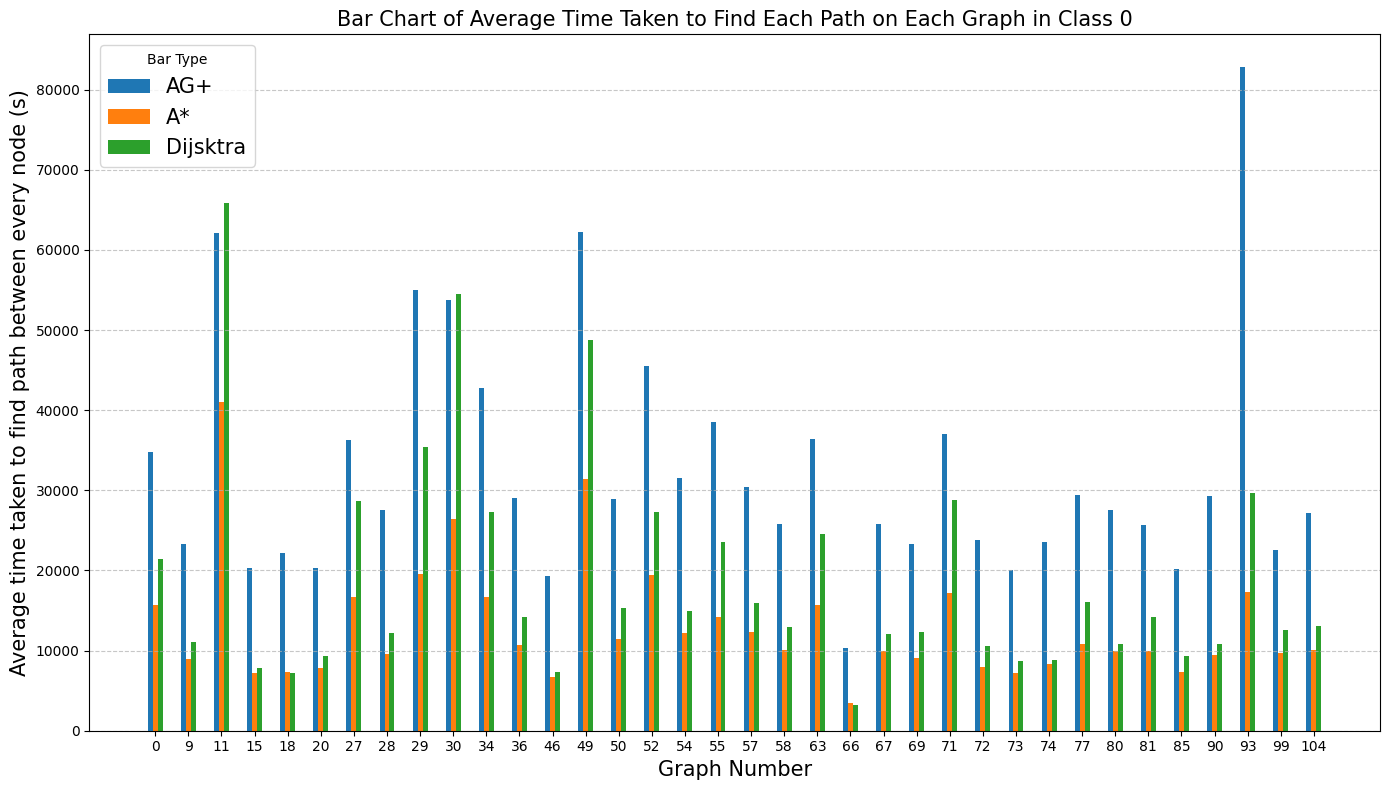

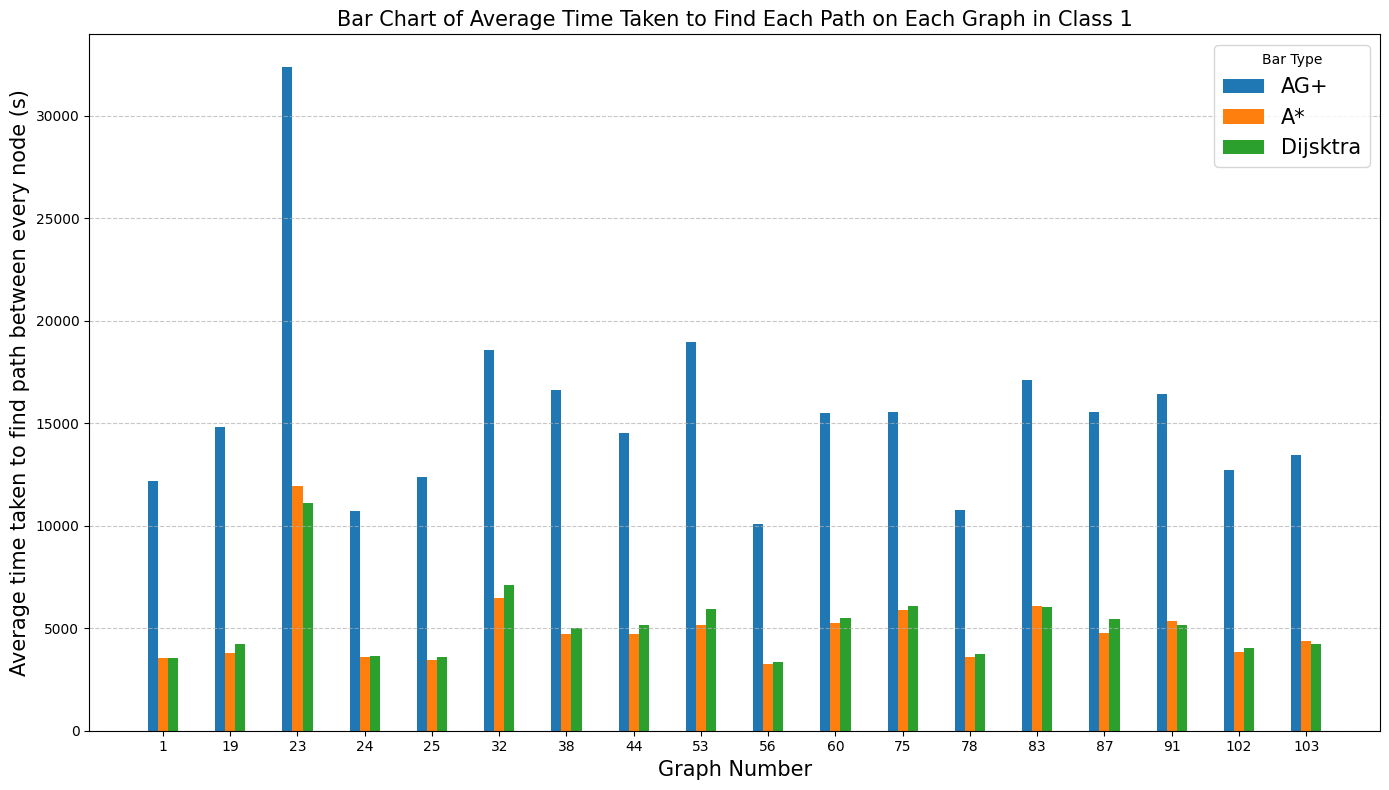

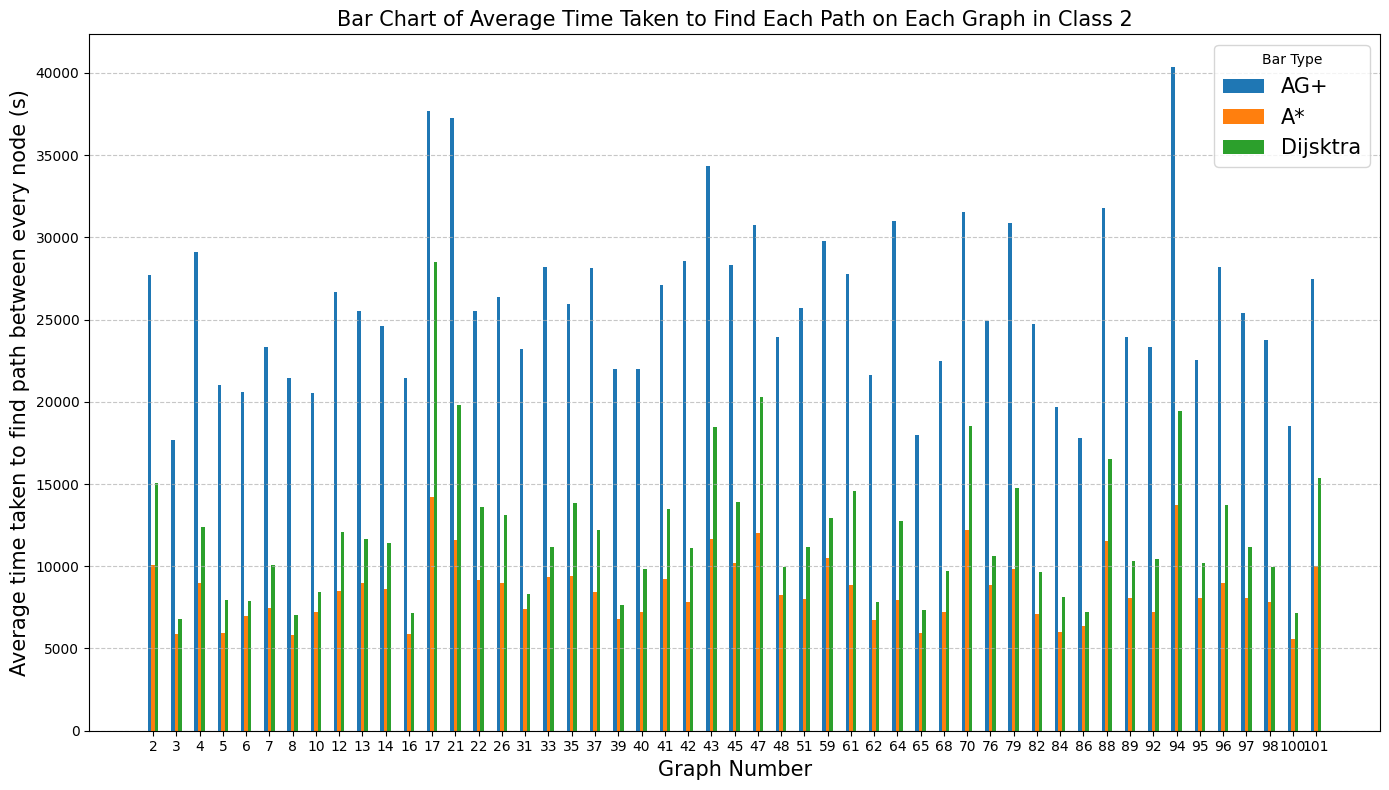

In [175]:

""" Plot the cpu time for each algorithm on each graph for class 0 """


# Prepare data for plotting
keys = list(cpu_time_0.keys())
values = [v[2:5] for v in cpu_time_0.values()]  # Use only the first 5 values per key

# Create the figure
fig, ax = plt.subplots(figsize=(14, 8))

# Define x locations for each group of bars
x = np.arange(len(keys))  # Position of groups on x-axis
bar_width = 0.15  # Width of each bar
num_bars = len(values[0])  # Number of bars per group

# Define custom labels for the legend
labels = ['AG+', 'A*', "Dijsktra"]

# Plot each of the 4 bars for all keys
for i in range(num_bars):
    bar_positions = x + i * bar_width  # Offset each bar
    bar_values = [v[i] for v in values]
    ax.bar(bar_positions, bar_values, bar_width, label=labels[i])

# Set x-ticks to the middle of the grouped bars
ax.set_xticks(x + bar_width * (num_bars - 1) / 2)
ax.set_xticklabels(keys)

# Add labels, title, and legend
plt.xlabel('Graph Number', fontsize=15)
plt.ylabel('Average time taken to find path between every node (s)', fontsize=15)
plt.title('Bar Chart of Average Time Taken to Find Each Path on Each Graph in Class 0', fontsize=15)
plt.legend(title="Bar Type", fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig(f"Graphs Images/Class 0 (AG+ only) - Av. time taken fo each path against num of hops.png", dpi=300)
plt.show()

""" Plot the cpu time for each algorithm on each graph for class 1 """

# Prepare data for plotting
keys = list(cpu_time_1.keys())
values = [v[2:5] for v in cpu_time_1.values()]  # Use only the first 5 values per key

# Create the figure
fig, ax = plt.subplots(figsize=(14, 8))

# Define x locations for each group of bars
x = np.arange(len(keys))  # Position of groups on x-axis
bar_width = 0.15  # Width of each bar   
num_bars = len(values[0])  # Number of bars per group

# Define custom labels for the legend
labels = ['AG+', 'A*', "Dijsktra"]

# Plot each of the 4 bars for all keys
for i in range(num_bars):
    bar_positions = x + i * bar_width  # Offset each bar
    bar_values = [v[i] for v in values]
    ax.bar(bar_positions, bar_values, bar_width, label=labels[i])

# Set x-ticks to the middle of the grouped bars
ax.set_xticks(x + bar_width * (num_bars - 1) / 2)
ax.set_xticklabels(keys)

# Add labels, title, and legend
plt.xlabel('Graph Number', fontsize=15)
plt.ylabel('Average time taken to find path between every node (s)', fontsize=15)
plt.title('Bar Chart of Average Time Taken to Find Each Path on Each Graph in Class 1', fontsize=15)
plt.legend(title="Bar Type", fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig(f"Graphs Images/Class 1 (AG+ only) - Av. time taken fo each path against num of hops.png", dpi=300)
plt.show()

""" Plot the cpu time for each algorithm on each graph for class 2 """

# Prepare data for plotting
keys = list(cpu_time_2.keys())
values = [v[2:5] for v in cpu_time_2.values()]  # Use only the last 3 values per key

# Create the figure
fig, ax = plt.subplots(figsize=(14, 8))

# Define x locations for each group of bars
x = np.arange(len(keys))  # Position of groups on x-axis
bar_width = 0.15  # Width of each bar
num_bars = len(values[0])  # Number of bars per group

# Define custom labels for the legend
labels = ['AG+', 'A*', "Dijsktra"]

# Plot each of the 4 bars for all keys
for i in range(num_bars):
    bar_positions = x + i * bar_width  # Offset each bar
    bar_values = [v[i] for v in values]
    ax.bar(bar_positions, bar_values, bar_width, label=labels[i])

# Set x-ticks to the middle of the grouped bars
ax.set_xticks(x + bar_width * (num_bars - 1) / 2)
ax.set_xticklabels(keys)

# Add labels, title, and legend
plt.xlabel('Graph Number', fontsize=15)
plt.ylabel('Average time taken to find path between every node (s)', fontsize=15)
plt.title('Bar Chart of Average Time Taken to Find Each Path on Each Graph in Class 2', fontsize=15)
plt.legend(title="Bar Type", fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig(f"Graphs Images/Class 2 (AG+ only) - Av. time taken fo each path against num of hops.png", dpi=300)
plt.show()

## Shows the average difference of cpu time necessary to calculate all paths for each algorithm agaisnt Dijkstra, sorted by classes

In [176]:
cpu_time_diff_0 = {}
cpu_time_diff_1 = {}
cpu_time_diff_2 = {}

for graph in cpu_time_0.keys():
    cpu_time_diff_0[graph] = [cpu_time_0[graph][0]-cpu_time_0[graph][4], cpu_time_0[graph][1]-cpu_time_0[graph][4], cpu_time_0[graph][2]-cpu_time_0[graph][4], cpu_time_0[graph][3]-cpu_time_0[graph][4]]

for graph in cpu_time_1.keys():
    cpu_time_diff_1[graph] = [cpu_time_1[graph][0]-cpu_time_1[graph][4], cpu_time_1[graph][1]-cpu_time_1[graph][4], cpu_time_1[graph][2]-cpu_time_1[graph][4], cpu_time_1[graph][3]-cpu_time_1[graph][4]]

for graph in cpu_time_2.keys():
    cpu_time_diff_2[graph] = [cpu_time_2[graph][0]-cpu_time_2[graph][4], cpu_time_2[graph][1]-cpu_time_2[graph][4], cpu_time_2[graph][2]-cpu_time_2[graph][4], cpu_time_2[graph][3]-cpu_time_2[graph][4]]
    


## Shows the average difference of cpu time necessary to calculate all paths for AG+ and A* agaisnt Dijkstra, sorted by classes

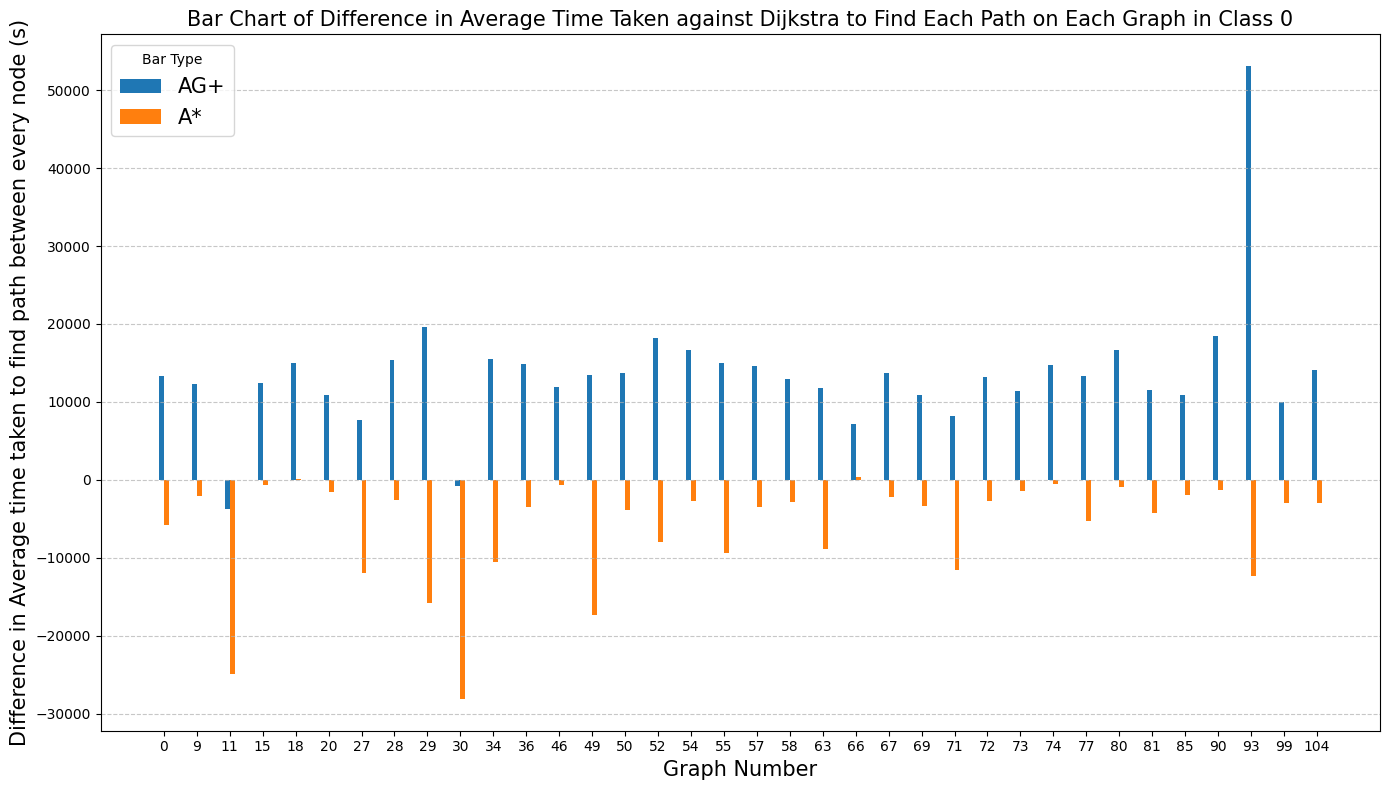

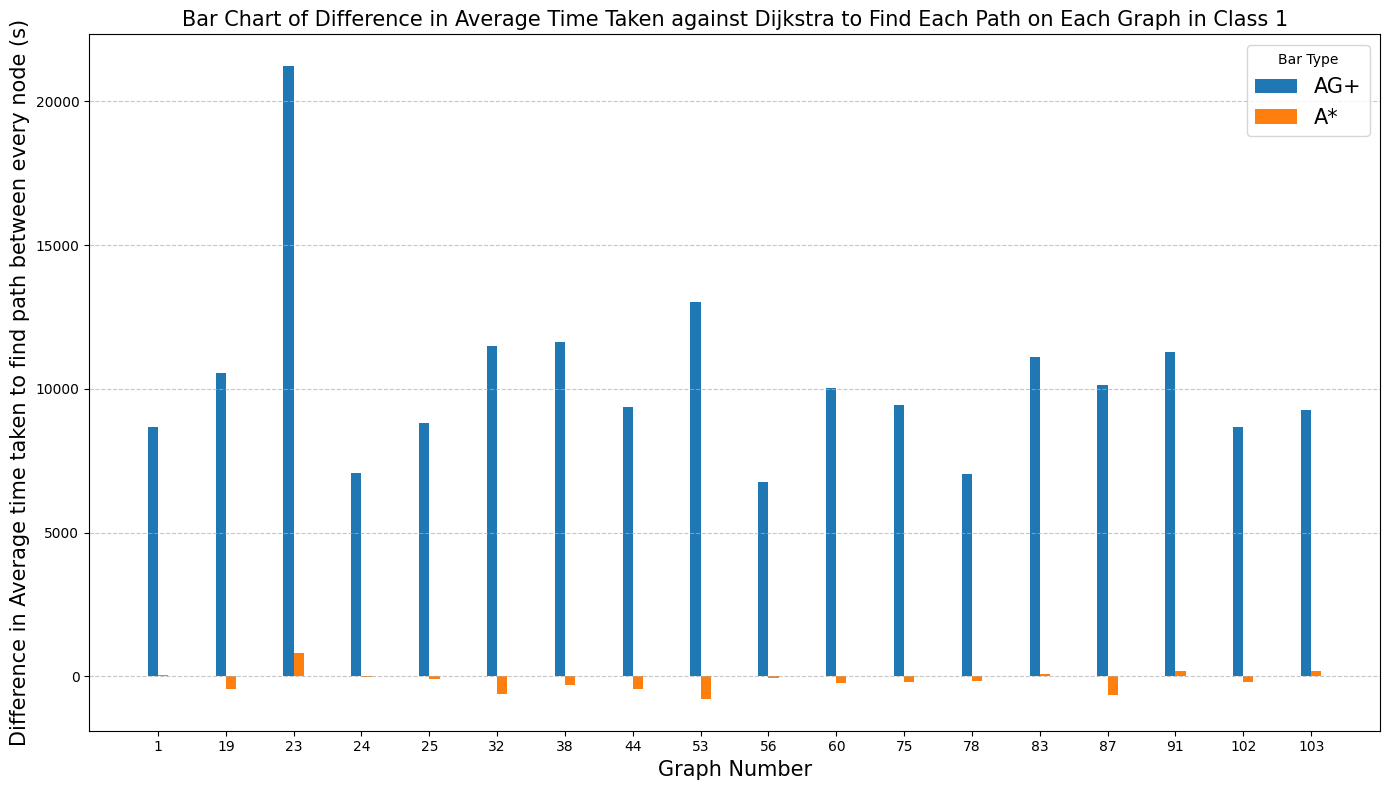

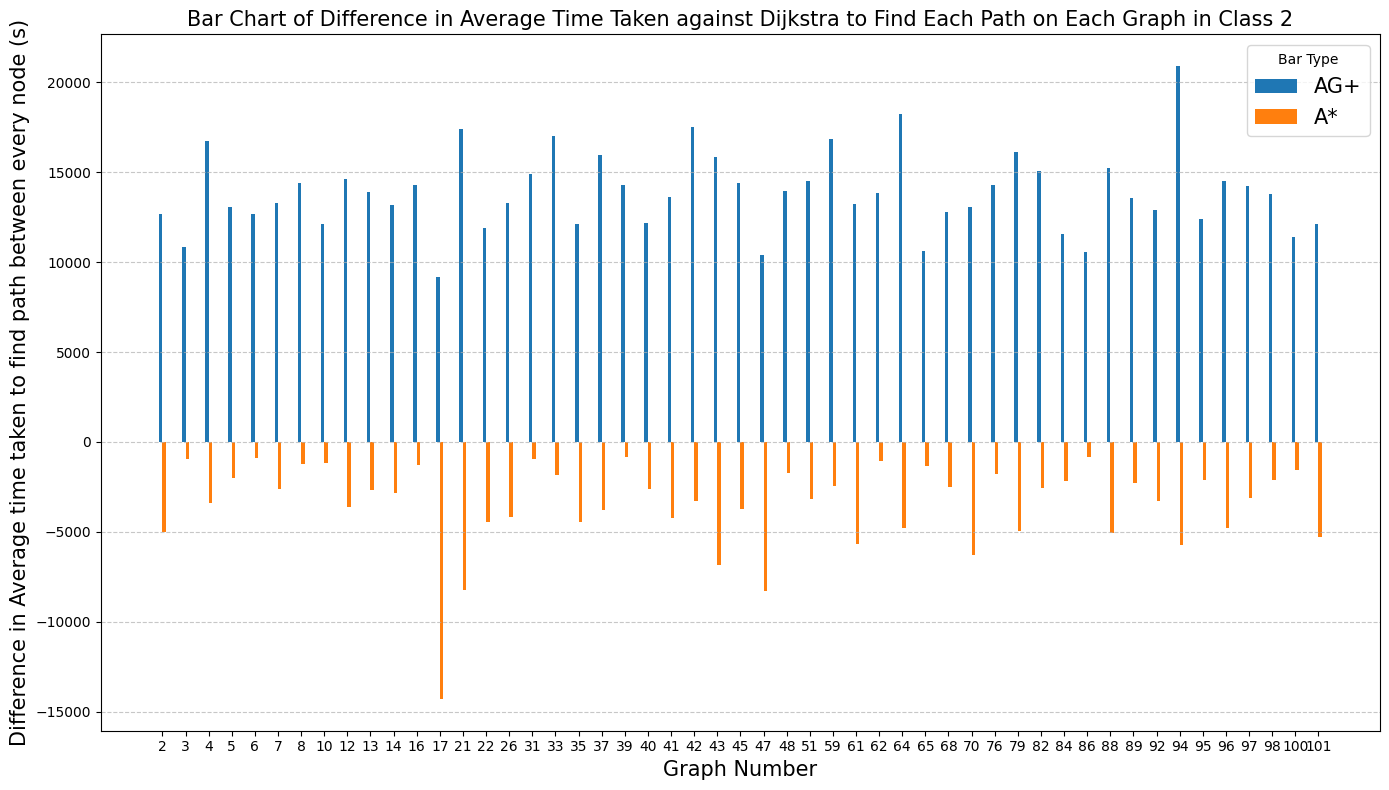

In [177]:
""" Plot the difference of cpu time for each algorithm on each graph for class 0 """
# Prepare data for plotting
keys = list(cpu_time_diff_0.keys())
values = [v[2:4] for v in cpu_time_diff_0.values()]  # Use only the first 4 values per key

# Create the figure
fig, ax = plt.subplots(figsize=(14, 8))

# Define x locations for each group of bars
x = np.arange(len(keys))  # Position of groups on x-axis
bar_width = 0.15  # Width of each bar
num_bars = len(values[0])  # Number of bars per group

# Define custom labels for the legend
labels = ['AG+', 'A*']

# Plot each of the 4 bars for all keys
for i in range(num_bars):
    bar_positions = x + i * bar_width  # Offset each bar
    bar_values = [v[i] for v in values]
    ax.bar(bar_positions, bar_values, bar_width, label=labels[i])

# Set x-ticks to the middle of the grouped bars
ax.set_xticks(x + bar_width * (num_bars - 1) / 2)
ax.set_xticklabels(keys)

# Add labels, title, and legend
plt.xlabel('Graph Number', fontsize=15)
plt.ylabel('Difference in Average time taken to find path between every node (s)', fontsize=15)
plt.title('Bar Chart of Difference in Average Time Taken against Dijkstra to Find Each Path on Each Graph in Class 0', fontsize=15)
plt.legend(title="Bar Type", fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig(f"Graphs Images/Class 0 (AG+ only) - Diff in Av. time against Dijkstra.png", dpi=300)
plt.show()


""" Plot the difference of cpu time for each algorithm on each graph for class 1 """

# Prepare data for plotting
keys = list(cpu_time_diff_1.keys())
values = [v[2:4] for v in cpu_time_diff_1.values()]  # Use only the first 4 values per key

# Create the figure
fig, ax = plt.subplots(figsize=(14, 8))

# Define x locations for each group of bars
x = np.arange(len(keys))  # Position of groups on x-axis
bar_width = 0.15  # Width of each bar   
num_bars = len(values[0])  # Number of bars per group

# Define custom labels for the legend
labels = ['AG+', 'A*']

# Plot each of the 4 bars for all keys
for i in range(num_bars):
    bar_positions = x + i * bar_width  # Offset each bar
    bar_values = [v[i] for v in values]
    ax.bar(bar_positions, bar_values, bar_width, label=labels[i])

# Set x-ticks to the middle of the grouped bars
ax.set_xticks(x + bar_width * (num_bars - 1) / 2)
ax.set_xticklabels(keys)

# Add labels, title, and legend
plt.xlabel('Graph Number', fontsize=15)
plt.ylabel('Difference in Average time taken to find path between every node (s)', fontsize=15)
plt.title('Bar Chart of Difference in Average Time Taken against Dijkstra to Find Each Path on Each Graph in Class 1', fontsize=15)
plt.legend(title="Bar Type", fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig(f"Graphs Images/Class 1 (AG+ only) - Diff in Av. time against Dijkstra.png", dpi=300)
plt.show()


""" Plot the difference of cpu time for each algorithm on each graph for class 2 """

# Prepare data for plotting
keys = list(cpu_time_diff_2.keys())
values = [v[2:4] for v in cpu_time_diff_2.values()]  # Use only the last 3 values per key

# Create the figure
fig, ax = plt.subplots(figsize=(14, 8))

# Define x locations for each group of bars
x = np.arange(len(keys))  # Position of groups on x-axis
bar_width = 0.15  # Width of each bar
num_bars = len(values[0])  # Number of bars per group

# Define custom labels for the legend
labels = ['AG+', 'A*']

# Plot each of the 4 bars for all keys
for i in range(num_bars):
    bar_positions = x + i * bar_width  # Offset each bar
    bar_values = [v[i] for v in values]
    ax.bar(bar_positions, bar_values, bar_width, label=labels[i])

# Set x-ticks to the middle of the grouped bars
ax.set_xticks(x + bar_width * (num_bars - 1) / 2)
ax.set_xticklabels(keys)

# Add labels, title, and legend
plt.xlabel('Graph Number', fontsize=15)
plt.ylabel('Difference in Average time taken to find path between every node (s)', fontsize=15)
plt.title('Bar Chart of Difference in Average Time Taken against Dijkstra to Find Each Path on Each Graph in Class 2', fontsize=15)
plt.legend(title="Bar Type", fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig(f"Graphs Images/Class 2 (AG+ only) - Diff in Av. time against Dijkstra.png", dpi=300)
plt.show()